<a href="https://colab.research.google.com/github/sabeesh90/EVA6_S7/blob/main/Depth_wise_convolution_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth wise convolution parallel file part 2

##### Importing requisite libraries

In [1]:
!pip install albumentations==0.4.6
import torch
from torchvision import datasets
from google.colab import drive
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from torch.optim.lr_scheduler import StepLR
from torch import optim
from torch.optim.lr_scheduler import OneCycleLR

     |████████████████████████████████| 122kB 13.4MB/s 
     |████████████████████████████████| 952kB 21.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=4e58ee2598942a5c629a1fcbbed936f9f4ff943a47eb3d909c1b4ce41c02bae9
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


##### Mounting the google drive to import the model

In [2]:
# mount the drive where we will save stats and loade our libraries from
# from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
%cd drive/MyDrive/Colab Notebooks/EVA6

/content/drive/MyDrive/Colab Notebooks/EVA6


##### Using cuda for running models on GPU

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [7]:
import eva6_ass7_model
from  eva6_ass7_model import CifarNet5, CifarNet7, CifarNet9,CifarNet12 

In [8]:
model5 = CifarNet5()
model7 = CifarNet7()
model9 = CifarNet9()
model12 = CifarNet12()


##### Finding the mean and std for normaliation of images. 

In [9]:
n=0
s = np.zeros(3)
sq = np.zeros(3)
mean = np.zeros(3)
variance = np.zeros(3)
stand_dev = np.zeros(3)
count = 0

for data, l in tqdm_notebook(train):
  # print(np.array(data).shape)
  x = np.array(data)/255
  # print(x.shape)
  s += x.sum(axis=(0,1)) # this needs to be explained here (why 0,1). how does this work and why normalize and why not just scale to between 0 to 1 by dividing it by 255
  sq += np.sum(np.square(x), axis=(0,1))  # the squared sum is calculated here for what purpose?
  n += x.shape[0]*x.shape[1]
  # print(s)
  # print(n)

  mean+=s/n
  variance += np.square(s - mean)
  stand_dev += np.sqrt(variance/n)
  count+=1

# here mean is calculated across all the channels  and  not just one channel
mu = s/n
# std = np.sqrt((s/n - mu)/1024)
std = np.sqrt((sq/n - np.square(mu))) # how is this  equal to standard deviation?
print(mu, sq/n, std, n)
print(mean/count, stand_dev/count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000
[0.49196659 0.48229005 0.4461573 ] [227115.06139745 222630.84598793 205985.90869157]


In [10]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/EVA6')

##### Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [11]:
import torchvision
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [12]:
import numpy as np
from torchvision import transforms

import numpy as np
from torchvision import transforms
from albumentations.pytorch.transforms import ToTensor

channel_means = (0.49196659, 0.48229005, 0.4461573)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
fillmeans = tuple((np.array(channel_means)*255).astype(np.uint8))
# this is  to fill the empty spaces with  means of the channels multiplies by 255 to revert back to an image in that range
print(fillmeans, 'This is the value filled  at the time of rotation')
train_transforms = A.Compose([A.ShiftScaleRotate((-12.5,12.5)),
                              A.HorizontalFlip(),
                              A.ToGray(),
                              A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=4, min_width=4, fill_value=channel_means),                                                  
                              A.Normalize(mean=channel_means, std=channel_stdevs),
                              ToTensor(),
                              ])

# Test Phase transformations
test_transforms = A.Compose([A.Normalize(mean=channel_means, std=channel_stdevs), ToTensor(),])


(125, 122, 113) This is the value filled  at the time of rotation


##### Dataset and Creating Train/Test Split

In [13]:
from torchvision import datasets
train = Cifar10SearchDataset( train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset( train=False, download=True, transform=test_transforms)


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
Files already downloaded and verified


##### Dataloader Arguments & Test/Train Dataloaders


In [14]:
seed = 1
batch_size = 64

cuda = torch.cuda.is_available()    
if cuda:
    torch.cuda.manual_seed(seed)
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

##### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([64, 3, 32, 32])
torch.Size([64])


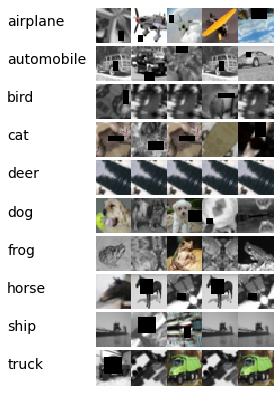

In [15]:
from __future__ import print_function
channel_means = (0.49196659, 0.48229005, 0.4461573)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

##### Training function

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

##### Base model

##### Model 5 - Similar to model 2 and model 4 but has 1x1 convolution at the end of max pool like block to concatenate features

In [17]:
model5 = CifarNet5().to(device)
summary(model5, input_size=(3, 32, 32))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
            Conv2d-9           [-1, 16, 16, 16]             160
           Conv2d-10           [-1, 32, 16, 16]             544
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1, 32,

In [16]:
EPOCHS = 250
optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model5, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model5, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.6618070602416992 Batch_id=781 Accuracy=30.98: 100%|██████████| 782/782 [00:14<00:00, 52.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5287, Accuracy: 4393/10000 (43.93%)

EPOCH: 1


Loss=1.38800048828125 Batch_id=781 Accuracy=39.12: 100%|██████████| 782/782 [00:14<00:00, 53.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3366, Accuracy: 5172/10000 (51.72%)

EPOCH: 2


Loss=1.433044672012329 Batch_id=781 Accuracy=43.56: 100%|██████████| 782/782 [00:14<00:00, 53.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2209, Accuracy: 5604/10000 (56.04%)

EPOCH: 3


Loss=1.4853521585464478 Batch_id=781 Accuracy=46.58: 100%|██████████| 782/782 [00:14<00:00, 53.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1249, Accuracy: 5993/10000 (59.93%)

EPOCH: 4


Loss=1.776958703994751 Batch_id=781 Accuracy=49.16: 100%|██████████| 782/782 [00:14<00:00, 52.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0427, Accuracy: 6312/10000 (63.12%)

EPOCH: 5


Loss=1.8022764921188354 Batch_id=781 Accuracy=51.10: 100%|██████████| 782/782 [00:14<00:00, 53.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0494, Accuracy: 6287/10000 (62.87%)

EPOCH: 6


Loss=1.4531450271606445 Batch_id=781 Accuracy=52.64: 100%|██████████| 782/782 [00:14<00:00, 53.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0084, Accuracy: 6381/10000 (63.81%)

EPOCH: 7


Loss=1.6875485181808472 Batch_id=781 Accuracy=53.95: 100%|██████████| 782/782 [00:14<00:00, 52.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9556, Accuracy: 6666/10000 (66.66%)

EPOCH: 8


Loss=2.00883150100708 Batch_id=781 Accuracy=54.49: 100%|██████████| 782/782 [00:14<00:00, 52.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9416, Accuracy: 6698/10000 (66.98%)

EPOCH: 9


Loss=1.148578405380249 Batch_id=781 Accuracy=55.60: 100%|██████████| 782/782 [00:14<00:00, 53.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8756, Accuracy: 6923/10000 (69.23%)

EPOCH: 10


Loss=0.7948698401451111 Batch_id=781 Accuracy=56.69: 100%|██████████| 782/782 [00:14<00:00, 53.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8404, Accuracy: 7087/10000 (70.87%)

EPOCH: 11


Loss=0.9065016508102417 Batch_id=781 Accuracy=57.66: 100%|██████████| 782/782 [00:14<00:00, 53.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8187, Accuracy: 7113/10000 (71.13%)

EPOCH: 12


Loss=1.3444503545761108 Batch_id=781 Accuracy=58.64: 100%|██████████| 782/782 [00:14<00:00, 52.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8092, Accuracy: 7203/10000 (72.03%)

EPOCH: 13


Loss=1.8193916082382202 Batch_id=781 Accuracy=59.49: 100%|██████████| 782/782 [00:14<00:00, 52.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7786, Accuracy: 7268/10000 (72.68%)

EPOCH: 14


Loss=1.2226295471191406 Batch_id=781 Accuracy=59.73: 100%|██████████| 782/782 [00:14<00:00, 52.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7964, Accuracy: 7250/10000 (72.50%)

EPOCH: 15


Loss=1.1015883684158325 Batch_id=781 Accuracy=60.15: 100%|██████████| 782/782 [00:14<00:00, 52.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7741, Accuracy: 7349/10000 (73.49%)

EPOCH: 16


Loss=0.973093569278717 Batch_id=781 Accuracy=61.04: 100%|██████████| 782/782 [00:14<00:00, 52.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7762, Accuracy: 7296/10000 (72.96%)

EPOCH: 17


Loss=1.4037307500839233 Batch_id=781 Accuracy=61.40: 100%|██████████| 782/782 [00:14<00:00, 52.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7302, Accuracy: 7440/10000 (74.40%)

EPOCH: 18


Loss=1.0128452777862549 Batch_id=781 Accuracy=61.77: 100%|██████████| 782/782 [00:14<00:00, 52.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6889, Accuracy: 7604/10000 (76.04%)

EPOCH: 19


Loss=0.9748905897140503 Batch_id=781 Accuracy=62.42: 100%|██████████| 782/782 [00:14<00:00, 52.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7170, Accuracy: 7517/10000 (75.17%)

EPOCH: 20


Loss=1.1481716632843018 Batch_id=781 Accuracy=63.05: 100%|██████████| 782/782 [00:14<00:00, 52.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6888, Accuracy: 7649/10000 (76.49%)

EPOCH: 21


Loss=2.416682481765747 Batch_id=781 Accuracy=63.39: 100%|██████████| 782/782 [00:15<00:00, 51.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6845, Accuracy: 7637/10000 (76.37%)

EPOCH: 22


Loss=1.0454983711242676 Batch_id=781 Accuracy=63.59: 100%|██████████| 782/782 [00:16<00:00, 47.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6689, Accuracy: 7704/10000 (77.04%)

EPOCH: 23


Loss=0.8651019930839539 Batch_id=781 Accuracy=63.64: 100%|██████████| 782/782 [00:15<00:00, 51.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6767, Accuracy: 7682/10000 (76.82%)

EPOCH: 24


Loss=1.2245794534683228 Batch_id=781 Accuracy=64.33: 100%|██████████| 782/782 [00:15<00:00, 51.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6476, Accuracy: 7744/10000 (77.44%)

EPOCH: 25


Loss=0.8124319314956665 Batch_id=781 Accuracy=64.48: 100%|██████████| 782/782 [00:14<00:00, 52.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6337, Accuracy: 7816/10000 (78.16%)

EPOCH: 26


Loss=1.1897764205932617 Batch_id=781 Accuracy=64.80: 100%|██████████| 782/782 [00:15<00:00, 51.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6853, Accuracy: 7694/10000 (76.94%)

EPOCH: 27


Loss=0.9293779730796814 Batch_id=781 Accuracy=65.33: 100%|██████████| 782/782 [00:15<00:00, 52.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6436, Accuracy: 7819/10000 (78.19%)

EPOCH: 28


Loss=1.3192824125289917 Batch_id=781 Accuracy=65.62: 100%|██████████| 782/782 [00:15<00:00, 51.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6345, Accuracy: 7817/10000 (78.17%)

EPOCH: 29


Loss=1.435441017150879 Batch_id=781 Accuracy=65.85: 100%|██████████| 782/782 [00:14<00:00, 52.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6464, Accuracy: 7746/10000 (77.46%)

EPOCH: 30


Loss=1.0437759160995483 Batch_id=781 Accuracy=66.14: 100%|██████████| 782/782 [00:15<00:00, 51.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6132, Accuracy: 7891/10000 (78.91%)

EPOCH: 31


Loss=1.3473517894744873 Batch_id=781 Accuracy=66.14: 100%|██████████| 782/782 [00:14<00:00, 52.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6345, Accuracy: 7860/10000 (78.60%)

EPOCH: 32


Loss=0.8824766874313354 Batch_id=781 Accuracy=66.32: 100%|██████████| 782/782 [00:15<00:00, 51.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6185, Accuracy: 7851/10000 (78.51%)

EPOCH: 33


Loss=1.1126818656921387 Batch_id=781 Accuracy=66.74: 100%|██████████| 782/782 [00:15<00:00, 49.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5944, Accuracy: 7981/10000 (79.81%)

EPOCH: 34


Loss=0.682377815246582 Batch_id=781 Accuracy=66.62: 100%|██████████| 782/782 [00:15<00:00, 50.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6023, Accuracy: 7934/10000 (79.34%)

EPOCH: 35


Loss=0.8290166258811951 Batch_id=781 Accuracy=67.31: 100%|██████████| 782/782 [00:15<00:00, 51.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5848, Accuracy: 7986/10000 (79.86%)

EPOCH: 36


Loss=1.2045189142227173 Batch_id=781 Accuracy=67.30: 100%|██████████| 782/782 [00:15<00:00, 51.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5894, Accuracy: 7952/10000 (79.52%)

EPOCH: 37


Loss=0.8149153590202332 Batch_id=781 Accuracy=67.37: 100%|██████████| 782/782 [00:15<00:00, 51.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6061, Accuracy: 7941/10000 (79.41%)

EPOCH: 38


Loss=0.4001578092575073 Batch_id=781 Accuracy=67.93: 100%|██████████| 782/782 [00:15<00:00, 50.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6026, Accuracy: 7954/10000 (79.54%)

EPOCH: 39


Loss=0.5104772448539734 Batch_id=781 Accuracy=67.29: 100%|██████████| 782/782 [00:15<00:00, 51.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5868, Accuracy: 8010/10000 (80.10%)

EPOCH: 40


Loss=0.7117937207221985 Batch_id=781 Accuracy=68.18: 100%|██████████| 782/782 [00:15<00:00, 51.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5861, Accuracy: 7944/10000 (79.44%)

EPOCH: 41


Loss=1.52653968334198 Batch_id=781 Accuracy=68.49: 100%|██████████| 782/782 [00:15<00:00, 50.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5608, Accuracy: 8127/10000 (81.27%)

EPOCH: 42


Loss=1.4280354976654053 Batch_id=781 Accuracy=68.63: 100%|██████████| 782/782 [00:15<00:00, 51.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5580, Accuracy: 8116/10000 (81.16%)

EPOCH: 43


Loss=0.7687241435050964 Batch_id=781 Accuracy=68.59: 100%|██████████| 782/782 [00:15<00:00, 51.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5605, Accuracy: 8121/10000 (81.21%)

EPOCH: 44


Loss=1.163227915763855 Batch_id=781 Accuracy=68.74: 100%|██████████| 782/782 [00:15<00:00, 50.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5895, Accuracy: 8004/10000 (80.04%)

EPOCH: 45


Loss=0.7853100895881653 Batch_id=781 Accuracy=68.89: 100%|██████████| 782/782 [00:15<00:00, 50.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5760, Accuracy: 8053/10000 (80.53%)

EPOCH: 46


Loss=0.9172507524490356 Batch_id=781 Accuracy=69.01: 100%|██████████| 782/782 [00:15<00:00, 51.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5704, Accuracy: 8000/10000 (80.00%)

EPOCH: 47


Loss=1.1288152933120728 Batch_id=781 Accuracy=69.14: 100%|██████████| 782/782 [00:15<00:00, 51.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5398, Accuracy: 8187/10000 (81.87%)

EPOCH: 48


Loss=0.9902061820030212 Batch_id=781 Accuracy=69.24: 100%|██████████| 782/782 [00:15<00:00, 50.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5522, Accuracy: 8126/10000 (81.26%)

EPOCH: 49


Loss=1.4180853366851807 Batch_id=781 Accuracy=69.37: 100%|██████████| 782/782 [00:15<00:00, 50.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5759, Accuracy: 8000/10000 (80.00%)

EPOCH: 50


Loss=1.3476941585540771 Batch_id=781 Accuracy=69.60: 100%|██████████| 782/782 [00:15<00:00, 51.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5465, Accuracy: 8119/10000 (81.19%)

EPOCH: 51


Loss=0.9450598955154419 Batch_id=781 Accuracy=69.90: 100%|██████████| 782/782 [00:15<00:00, 50.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5563, Accuracy: 8085/10000 (80.85%)

EPOCH: 52


Loss=1.0205382108688354 Batch_id=781 Accuracy=69.88: 100%|██████████| 782/782 [00:15<00:00, 50.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5451, Accuracy: 8112/10000 (81.12%)

EPOCH: 53


Loss=0.38968655467033386 Batch_id=781 Accuracy=70.35: 100%|██████████| 782/782 [00:15<00:00, 49.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5300, Accuracy: 8174/10000 (81.74%)

EPOCH: 54


Loss=1.7214715480804443 Batch_id=781 Accuracy=70.08: 100%|██████████| 782/782 [00:15<00:00, 49.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5499, Accuracy: 8146/10000 (81.46%)

EPOCH: 55


Loss=0.9010396599769592 Batch_id=781 Accuracy=70.12: 100%|██████████| 782/782 [00:15<00:00, 50.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5406, Accuracy: 8135/10000 (81.35%)

EPOCH: 56


Loss=1.2151657342910767 Batch_id=781 Accuracy=70.34: 100%|██████████| 782/782 [00:15<00:00, 50.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5274, Accuracy: 8190/10000 (81.90%)

EPOCH: 57


Loss=0.9016507267951965 Batch_id=781 Accuracy=70.23: 100%|██████████| 782/782 [00:15<00:00, 49.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5287, Accuracy: 8208/10000 (82.08%)

EPOCH: 58


Loss=0.67190021276474 Batch_id=781 Accuracy=70.74: 100%|██████████| 782/782 [00:15<00:00, 49.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5293, Accuracy: 8176/10000 (81.76%)

EPOCH: 59


Loss=0.9894818067550659 Batch_id=781 Accuracy=70.71: 100%|██████████| 782/782 [00:15<00:00, 50.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5300, Accuracy: 8178/10000 (81.78%)

EPOCH: 60


Loss=1.0443329811096191 Batch_id=781 Accuracy=70.80: 100%|██████████| 782/782 [00:15<00:00, 50.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5197, Accuracy: 8226/10000 (82.26%)

EPOCH: 61


Loss=1.1702752113342285 Batch_id=781 Accuracy=70.82: 100%|██████████| 782/782 [00:15<00:00, 50.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5353, Accuracy: 8231/10000 (82.31%)

EPOCH: 62


Loss=1.4439200162887573 Batch_id=781 Accuracy=71.03: 100%|██████████| 782/782 [00:15<00:00, 50.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5259, Accuracy: 8190/10000 (81.90%)

EPOCH: 63


Loss=1.0314542055130005 Batch_id=781 Accuracy=70.96: 100%|██████████| 782/782 [00:15<00:00, 50.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5089, Accuracy: 8258/10000 (82.58%)

EPOCH: 64


Loss=0.6241716146469116 Batch_id=781 Accuracy=71.20: 100%|██████████| 782/782 [00:15<00:00, 50.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5165, Accuracy: 8201/10000 (82.01%)

EPOCH: 65


Loss=0.4795735478401184 Batch_id=781 Accuracy=71.38: 100%|██████████| 782/782 [00:15<00:00, 51.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5257, Accuracy: 8201/10000 (82.01%)

EPOCH: 66


Loss=1.6680805683135986 Batch_id=781 Accuracy=71.36: 100%|██████████| 782/782 [00:14<00:00, 52.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5178, Accuracy: 8239/10000 (82.39%)

EPOCH: 67


Loss=0.7761547565460205 Batch_id=781 Accuracy=71.45: 100%|██████████| 782/782 [00:15<00:00, 51.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5027, Accuracy: 8289/10000 (82.89%)

EPOCH: 68


Loss=1.134213924407959 Batch_id=781 Accuracy=71.47: 100%|██████████| 782/782 [00:15<00:00, 52.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5117, Accuracy: 8282/10000 (82.82%)

EPOCH: 69


Loss=1.6225903034210205 Batch_id=781 Accuracy=71.83: 100%|██████████| 782/782 [00:14<00:00, 52.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5174, Accuracy: 8226/10000 (82.26%)

EPOCH: 70


Loss=0.6638656854629517 Batch_id=781 Accuracy=71.88: 100%|██████████| 782/782 [00:15<00:00, 51.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5120, Accuracy: 8273/10000 (82.73%)

EPOCH: 71


Loss=1.0198886394500732 Batch_id=781 Accuracy=71.49: 100%|██████████| 782/782 [00:14<00:00, 52.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5214, Accuracy: 8222/10000 (82.22%)

EPOCH: 72


Loss=1.252254605293274 Batch_id=781 Accuracy=72.11: 100%|██████████| 782/782 [00:15<00:00, 51.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5160, Accuracy: 8261/10000 (82.61%)

EPOCH: 73


Loss=0.6959238648414612 Batch_id=781 Accuracy=72.02: 100%|██████████| 782/782 [00:14<00:00, 52.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5028, Accuracy: 8286/10000 (82.86%)

EPOCH: 74


Loss=0.8495725393295288 Batch_id=781 Accuracy=72.04: 100%|██████████| 782/782 [00:14<00:00, 52.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5027, Accuracy: 8306/10000 (83.06%)

EPOCH: 75


Loss=1.1205508708953857 Batch_id=781 Accuracy=72.11: 100%|██████████| 782/782 [00:15<00:00, 52.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4962, Accuracy: 8293/10000 (82.93%)

EPOCH: 76


Loss=0.9280480146408081 Batch_id=781 Accuracy=72.38: 100%|██████████| 782/782 [00:14<00:00, 52.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4926, Accuracy: 8325/10000 (83.25%)

EPOCH: 77


Loss=0.7216597199440002 Batch_id=781 Accuracy=72.73: 100%|██████████| 782/782 [00:15<00:00, 51.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 8289/10000 (82.89%)

EPOCH: 78


Loss=1.419843077659607 Batch_id=781 Accuracy=72.32: 100%|██████████| 782/782 [00:14<00:00, 52.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5064, Accuracy: 8300/10000 (83.00%)

EPOCH: 79


Loss=1.222313642501831 Batch_id=781 Accuracy=72.78: 100%|██████████| 782/782 [00:15<00:00, 51.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4985, Accuracy: 8313/10000 (83.13%)

EPOCH: 80


Loss=1.2511416673660278 Batch_id=781 Accuracy=72.61: 100%|██████████| 782/782 [00:15<00:00, 51.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5022, Accuracy: 8302/10000 (83.02%)

EPOCH: 81


Loss=1.8386356830596924 Batch_id=781 Accuracy=72.43: 100%|██████████| 782/782 [00:15<00:00, 51.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5179, Accuracy: 8260/10000 (82.60%)

EPOCH: 82


Loss=0.5117514133453369 Batch_id=781 Accuracy=73.00: 100%|██████████| 782/782 [00:15<00:00, 51.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4965, Accuracy: 8280/10000 (82.80%)

EPOCH: 83


Loss=0.41189807653427124 Batch_id=781 Accuracy=72.86: 100%|██████████| 782/782 [00:15<00:00, 51.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4945, Accuracy: 8344/10000 (83.44%)

EPOCH: 84


Loss=0.4366781711578369 Batch_id=781 Accuracy=73.20: 100%|██████████| 782/782 [00:15<00:00, 51.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5083, Accuracy: 8298/10000 (82.98%)

EPOCH: 85


Loss=0.7010909914970398 Batch_id=781 Accuracy=72.55: 100%|██████████| 782/782 [00:15<00:00, 51.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5058, Accuracy: 8280/10000 (82.80%)

EPOCH: 86


Loss=0.9434102773666382 Batch_id=781 Accuracy=73.08: 100%|██████████| 782/782 [00:15<00:00, 51.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4992, Accuracy: 8342/10000 (83.42%)

EPOCH: 87


Loss=0.939697802066803 Batch_id=781 Accuracy=73.16: 100%|██████████| 782/782 [00:15<00:00, 51.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4803, Accuracy: 8372/10000 (83.72%)

EPOCH: 88


Loss=1.0233746767044067 Batch_id=781 Accuracy=73.13: 100%|██████████| 782/782 [00:15<00:00, 51.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4789, Accuracy: 8372/10000 (83.72%)

EPOCH: 89


Loss=0.696029007434845 Batch_id=781 Accuracy=73.31: 100%|██████████| 782/782 [00:15<00:00, 51.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4860, Accuracy: 8375/10000 (83.75%)

EPOCH: 90


Loss=1.610722303390503 Batch_id=781 Accuracy=73.36: 100%|██████████| 782/782 [00:15<00:00, 51.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4847, Accuracy: 8324/10000 (83.24%)

EPOCH: 91


Loss=0.9052747488021851 Batch_id=781 Accuracy=73.06: 100%|██████████| 782/782 [00:15<00:00, 51.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4835, Accuracy: 8324/10000 (83.24%)

EPOCH: 92


Loss=0.5457764267921448 Batch_id=781 Accuracy=73.40: 100%|██████████| 782/782 [00:15<00:00, 51.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4804, Accuracy: 8376/10000 (83.76%)

EPOCH: 93


Loss=0.6530488133430481 Batch_id=781 Accuracy=73.62: 100%|██████████| 782/782 [00:15<00:00, 51.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4744, Accuracy: 8425/10000 (84.25%)

EPOCH: 94


Loss=1.0063525438308716 Batch_id=781 Accuracy=73.26: 100%|██████████| 782/782 [00:15<00:00, 52.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4861, Accuracy: 8357/10000 (83.57%)

EPOCH: 95


Loss=1.1003084182739258 Batch_id=781 Accuracy=73.53: 100%|██████████| 782/782 [00:15<00:00, 51.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4911, Accuracy: 8368/10000 (83.68%)

EPOCH: 96


Loss=1.3083417415618896 Batch_id=781 Accuracy=73.64: 100%|██████████| 782/782 [00:15<00:00, 51.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4832, Accuracy: 8366/10000 (83.66%)

EPOCH: 97


Loss=0.6320959329605103 Batch_id=781 Accuracy=73.75: 100%|██████████| 782/782 [00:15<00:00, 51.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4763, Accuracy: 8406/10000 (84.06%)

EPOCH: 98


Loss=1.3190795183181763 Batch_id=781 Accuracy=73.83: 100%|██████████| 782/782 [00:15<00:00, 51.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4864, Accuracy: 8352/10000 (83.52%)

EPOCH: 99


Loss=0.9050025343894958 Batch_id=781 Accuracy=73.91: 100%|██████████| 782/782 [00:15<00:00, 51.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5019, Accuracy: 8334/10000 (83.34%)

EPOCH: 100


Loss=0.9354287385940552 Batch_id=781 Accuracy=73.99: 100%|██████████| 782/782 [00:15<00:00, 51.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4833, Accuracy: 8347/10000 (83.47%)

EPOCH: 101


Loss=0.8519628047943115 Batch_id=781 Accuracy=73.98: 100%|██████████| 782/782 [00:15<00:00, 51.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4786, Accuracy: 8422/10000 (84.22%)

EPOCH: 102


Loss=0.7004717588424683 Batch_id=781 Accuracy=74.00: 100%|██████████| 782/782 [00:15<00:00, 51.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4665, Accuracy: 8407/10000 (84.07%)

EPOCH: 103


Loss=0.8228746652603149 Batch_id=781 Accuracy=74.29: 100%|██████████| 782/782 [00:15<00:00, 51.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4836, Accuracy: 8379/10000 (83.79%)

EPOCH: 104


Loss=0.7840248346328735 Batch_id=781 Accuracy=74.18: 100%|██████████| 782/782 [00:15<00:00, 51.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4664, Accuracy: 8459/10000 (84.59%)

EPOCH: 105


Loss=0.8954617381095886 Batch_id=781 Accuracy=74.22: 100%|██████████| 782/782 [00:15<00:00, 50.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4856, Accuracy: 8366/10000 (83.66%)

EPOCH: 106


Loss=0.8991220593452454 Batch_id=781 Accuracy=74.24: 100%|██████████| 782/782 [00:15<00:00, 51.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4765, Accuracy: 8410/10000 (84.10%)

EPOCH: 107


Loss=0.784808337688446 Batch_id=781 Accuracy=74.42: 100%|██████████| 782/782 [00:15<00:00, 51.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4745, Accuracy: 8447/10000 (84.47%)

EPOCH: 108


Loss=1.1655668020248413 Batch_id=781 Accuracy=74.15: 100%|██████████| 782/782 [00:15<00:00, 51.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4845, Accuracy: 8372/10000 (83.72%)

EPOCH: 109


Loss=0.7642749547958374 Batch_id=781 Accuracy=74.26: 100%|██████████| 782/782 [00:15<00:00, 51.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4722, Accuracy: 8394/10000 (83.94%)

EPOCH: 110


Loss=0.9911791086196899 Batch_id=781 Accuracy=74.16: 100%|██████████| 782/782 [00:15<00:00, 50.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4816, Accuracy: 8402/10000 (84.02%)

EPOCH: 111


Loss=1.0408824682235718 Batch_id=781 Accuracy=74.74: 100%|██████████| 782/782 [00:15<00:00, 51.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4720, Accuracy: 8448/10000 (84.48%)

EPOCH: 112


Loss=0.5629279017448425 Batch_id=781 Accuracy=74.30: 100%|██████████| 782/782 [00:15<00:00, 51.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4766, Accuracy: 8367/10000 (83.67%)

EPOCH: 113


Loss=0.7533588409423828 Batch_id=781 Accuracy=74.51: 100%|██████████| 782/782 [00:15<00:00, 50.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4702, Accuracy: 8432/10000 (84.32%)

EPOCH: 114


Loss=0.6221500039100647 Batch_id=781 Accuracy=74.50: 100%|██████████| 782/782 [00:15<00:00, 50.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4832, Accuracy: 8396/10000 (83.96%)

EPOCH: 115


Loss=0.5143933892250061 Batch_id=781 Accuracy=74.65: 100%|██████████| 782/782 [00:15<00:00, 51.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4817, Accuracy: 8413/10000 (84.13%)

EPOCH: 116


Loss=0.3923516273498535 Batch_id=781 Accuracy=74.44: 100%|██████████| 782/782 [00:15<00:00, 50.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4881, Accuracy: 8379/10000 (83.79%)

EPOCH: 117


Loss=0.3763344883918762 Batch_id=781 Accuracy=74.80: 100%|██████████| 782/782 [00:15<00:00, 50.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4718, Accuracy: 8469/10000 (84.69%)

EPOCH: 118


Loss=0.5380401611328125 Batch_id=781 Accuracy=74.61: 100%|██████████| 782/782 [00:15<00:00, 50.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4716, Accuracy: 8453/10000 (84.53%)

EPOCH: 119


Loss=0.8609781265258789 Batch_id=781 Accuracy=74.64: 100%|██████████| 782/782 [00:15<00:00, 50.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4899, Accuracy: 8372/10000 (83.72%)

EPOCH: 120


Loss=0.6817668676376343 Batch_id=781 Accuracy=74.79: 100%|██████████| 782/782 [00:15<00:00, 51.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4712, Accuracy: 8449/10000 (84.49%)

EPOCH: 121


Loss=0.40460920333862305 Batch_id=781 Accuracy=74.91: 100%|██████████| 782/782 [00:15<00:00, 50.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4670, Accuracy: 8446/10000 (84.46%)

EPOCH: 122


Loss=0.5009686946868896 Batch_id=781 Accuracy=74.83: 100%|██████████| 782/782 [00:16<00:00, 48.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4815, Accuracy: 8392/10000 (83.92%)

EPOCH: 123


Loss=0.8451905250549316 Batch_id=781 Accuracy=74.90: 100%|██████████| 782/782 [00:15<00:00, 50.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4637, Accuracy: 8401/10000 (84.01%)

EPOCH: 124


Loss=0.7108983993530273 Batch_id=781 Accuracy=74.93: 100%|██████████| 782/782 [00:15<00:00, 51.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4702, Accuracy: 8447/10000 (84.47%)

EPOCH: 125


Loss=0.9314134120941162 Batch_id=781 Accuracy=74.82: 100%|██████████| 782/782 [00:15<00:00, 51.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4667, Accuracy: 8427/10000 (84.27%)

EPOCH: 126


Loss=0.7828719615936279 Batch_id=781 Accuracy=75.20: 100%|██████████| 782/782 [00:15<00:00, 50.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4713, Accuracy: 8457/10000 (84.57%)

EPOCH: 127


Loss=0.4838140308856964 Batch_id=781 Accuracy=75.15: 100%|██████████| 782/782 [00:15<00:00, 50.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4582, Accuracy: 8446/10000 (84.46%)

EPOCH: 128


Loss=0.35662731528282166 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:15<00:00, 50.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4746, Accuracy: 8432/10000 (84.32%)

EPOCH: 129


Loss=0.638039767742157 Batch_id=781 Accuracy=74.84: 100%|██████████| 782/782 [00:15<00:00, 50.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4744, Accuracy: 8464/10000 (84.64%)

EPOCH: 130


Loss=1.1106997728347778 Batch_id=781 Accuracy=75.28: 100%|██████████| 782/782 [00:15<00:00, 50.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4782, Accuracy: 8428/10000 (84.28%)

EPOCH: 131


Loss=0.8679728507995605 Batch_id=781 Accuracy=75.18: 100%|██████████| 782/782 [00:15<00:00, 49.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8443/10000 (84.43%)

EPOCH: 132


Loss=0.37908878922462463 Batch_id=781 Accuracy=75.50: 100%|██████████| 782/782 [00:15<00:00, 50.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4765, Accuracy: 8443/10000 (84.43%)

EPOCH: 133


Loss=0.3704686462879181 Batch_id=781 Accuracy=75.47: 100%|██████████| 782/782 [00:15<00:00, 50.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Accuracy: 8478/10000 (84.78%)

EPOCH: 134


Loss=1.4066641330718994 Batch_id=781 Accuracy=75.33: 100%|██████████| 782/782 [00:15<00:00, 50.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4717, Accuracy: 8455/10000 (84.55%)

EPOCH: 135


Loss=0.7456764578819275 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:15<00:00, 50.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4588, Accuracy: 8486/10000 (84.86%)

EPOCH: 136


Loss=0.6547738313674927 Batch_id=781 Accuracy=75.49: 100%|██████████| 782/782 [00:15<00:00, 51.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4635, Accuracy: 8463/10000 (84.63%)

EPOCH: 137


Loss=0.7467012405395508 Batch_id=781 Accuracy=75.64: 100%|██████████| 782/782 [00:15<00:00, 49.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4602, Accuracy: 8455/10000 (84.55%)

EPOCH: 138


Loss=0.8760018348693848 Batch_id=781 Accuracy=75.91: 100%|██████████| 782/782 [00:15<00:00, 50.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4666, Accuracy: 8480/10000 (84.80%)

EPOCH: 139


Loss=0.7557569742202759 Batch_id=781 Accuracy=75.60: 100%|██████████| 782/782 [00:15<00:00, 50.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4639, Accuracy: 8469/10000 (84.69%)

EPOCH: 140


Loss=1.076462745666504 Batch_id=781 Accuracy=75.59: 100%|██████████| 782/782 [00:15<00:00, 50.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4705, Accuracy: 8449/10000 (84.49%)

EPOCH: 141


Loss=0.7413097620010376 Batch_id=781 Accuracy=75.47: 100%|██████████| 782/782 [00:16<00:00, 48.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4849, Accuracy: 8437/10000 (84.37%)

EPOCH: 142


Loss=0.6088619828224182 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:16<00:00, 47.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4748, Accuracy: 8455/10000 (84.55%)

EPOCH: 143


Loss=1.4380134344100952 Batch_id=781 Accuracy=75.49: 100%|██████████| 782/782 [00:16<00:00, 47.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Accuracy: 8433/10000 (84.33%)

EPOCH: 144


Loss=0.8283677697181702 Batch_id=781 Accuracy=75.72: 100%|██████████| 782/782 [00:16<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4558, Accuracy: 8454/10000 (84.54%)

EPOCH: 145


Loss=0.8898611068725586 Batch_id=781 Accuracy=75.93: 100%|██████████| 782/782 [00:16<00:00, 47.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4617, Accuracy: 8490/10000 (84.90%)

EPOCH: 146


Loss=0.936432421207428 Batch_id=781 Accuracy=75.84: 100%|██████████| 782/782 [00:16<00:00, 47.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4723, Accuracy: 8436/10000 (84.36%)

EPOCH: 147


Loss=0.9451349973678589 Batch_id=781 Accuracy=76.02: 100%|██████████| 782/782 [00:16<00:00, 48.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4579, Accuracy: 8477/10000 (84.77%)

EPOCH: 148


Loss=1.1072545051574707 Batch_id=781 Accuracy=75.70: 100%|██████████| 782/782 [00:16<00:00, 48.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4579, Accuracy: 8475/10000 (84.75%)

EPOCH: 149


Loss=0.36431819200515747 Batch_id=781 Accuracy=75.65: 100%|██████████| 782/782 [00:16<00:00, 47.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4611, Accuracy: 8470/10000 (84.70%)

EPOCH: 150


Loss=0.5834072828292847 Batch_id=781 Accuracy=76.00: 100%|██████████| 782/782 [00:16<00:00, 47.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 8485/10000 (84.85%)

EPOCH: 151


Loss=0.39742282032966614 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:16<00:00, 47.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4675, Accuracy: 8465/10000 (84.65%)

EPOCH: 152


Loss=0.702414333820343 Batch_id=781 Accuracy=76.11: 100%|██████████| 782/782 [00:16<00:00, 48.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4593, Accuracy: 8509/10000 (85.09%)

EPOCH: 153


Loss=0.7669137716293335 Batch_id=781 Accuracy=76.10: 100%|██████████| 782/782 [00:16<00:00, 47.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4632, Accuracy: 8449/10000 (84.49%)

EPOCH: 154


Loss=0.6314684152603149 Batch_id=781 Accuracy=75.98: 100%|██████████| 782/782 [00:16<00:00, 48.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4611, Accuracy: 8449/10000 (84.49%)

EPOCH: 155


Loss=0.8087989687919617 Batch_id=781 Accuracy=76.17: 100%|██████████| 782/782 [00:16<00:00, 47.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4787, Accuracy: 8456/10000 (84.56%)

EPOCH: 156


Loss=0.7196690440177917 Batch_id=781 Accuracy=76.15: 100%|██████████| 782/782 [00:16<00:00, 48.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4622, Accuracy: 8449/10000 (84.49%)

EPOCH: 157


Loss=0.9289571642875671 Batch_id=781 Accuracy=76.35: 100%|██████████| 782/782 [00:16<00:00, 48.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4570, Accuracy: 8457/10000 (84.57%)

EPOCH: 158


Loss=0.592466413974762 Batch_id=781 Accuracy=76.31: 100%|██████████| 782/782 [00:16<00:00, 48.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4730, Accuracy: 8466/10000 (84.66%)

EPOCH: 159


Loss=1.2094886302947998 Batch_id=781 Accuracy=75.96: 100%|██████████| 782/782 [00:16<00:00, 48.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4582, Accuracy: 8517/10000 (85.17%)

EPOCH: 160


Loss=0.7251068353652954 Batch_id=781 Accuracy=76.56: 100%|██████████| 782/782 [00:16<00:00, 48.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4680, Accuracy: 8444/10000 (84.44%)

EPOCH: 161


Loss=0.31980329751968384 Batch_id=781 Accuracy=76.19: 100%|██████████| 782/782 [00:16<00:00, 48.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4627, Accuracy: 8476/10000 (84.76%)

EPOCH: 162


Loss=0.8349905014038086 Batch_id=781 Accuracy=76.35: 100%|██████████| 782/782 [00:16<00:00, 48.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4754, Accuracy: 8424/10000 (84.24%)

EPOCH: 163


Loss=0.6585803031921387 Batch_id=781 Accuracy=76.75: 100%|██████████| 782/782 [00:16<00:00, 48.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4622, Accuracy: 8488/10000 (84.88%)

EPOCH: 164


Loss=0.8503971695899963 Batch_id=781 Accuracy=76.28: 100%|██████████| 782/782 [00:16<00:00, 48.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4664, Accuracy: 8481/10000 (84.81%)

EPOCH: 165


Loss=0.44727379083633423 Batch_id=781 Accuracy=76.24: 100%|██████████| 782/782 [00:16<00:00, 48.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4564, Accuracy: 8459/10000 (84.59%)

EPOCH: 166


Loss=0.3368220329284668 Batch_id=781 Accuracy=76.64: 100%|██████████| 782/782 [00:16<00:00, 47.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4542, Accuracy: 8519/10000 (85.19%)

EPOCH: 167


Loss=0.3603072464466095 Batch_id=781 Accuracy=76.73: 100%|██████████| 782/782 [00:16<00:00, 48.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4781, Accuracy: 8457/10000 (84.57%)

EPOCH: 168


Loss=1.2426172494888306 Batch_id=781 Accuracy=76.46: 100%|██████████| 782/782 [00:16<00:00, 47.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4665, Accuracy: 8487/10000 (84.87%)

EPOCH: 169


Loss=1.181101679801941 Batch_id=781 Accuracy=76.49: 100%|██████████| 782/782 [00:16<00:00, 48.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4640, Accuracy: 8500/10000 (85.00%)

EPOCH: 170


Loss=0.3852267563343048 Batch_id=781 Accuracy=76.61: 100%|██████████| 782/782 [00:16<00:00, 47.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4496, Accuracy: 8538/10000 (85.38%)

EPOCH: 171


Loss=1.1351112127304077 Batch_id=781 Accuracy=76.60: 100%|██████████| 782/782 [00:16<00:00, 47.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4572, Accuracy: 8490/10000 (84.90%)

EPOCH: 172


Loss=0.5607391595840454 Batch_id=781 Accuracy=76.70: 100%|██████████| 782/782 [00:16<00:00, 48.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4596, Accuracy: 8525/10000 (85.25%)

EPOCH: 173


Loss=0.7019426226615906 Batch_id=781 Accuracy=76.55: 100%|██████████| 782/782 [00:16<00:00, 48.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Accuracy: 8514/10000 (85.14%)

EPOCH: 174


Loss=0.8826890587806702 Batch_id=781 Accuracy=76.49: 100%|██████████| 782/782 [00:16<00:00, 47.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4659, Accuracy: 8484/10000 (84.84%)

EPOCH: 175


Loss=0.9669316411018372 Batch_id=781 Accuracy=76.66: 100%|██████████| 782/782 [00:16<00:00, 48.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4471, Accuracy: 8548/10000 (85.48%)

EPOCH: 176


Loss=0.8569061160087585 Batch_id=781 Accuracy=76.67: 100%|██████████| 782/782 [00:16<00:00, 48.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4550, Accuracy: 8508/10000 (85.08%)

EPOCH: 177


Loss=0.8006730079650879 Batch_id=781 Accuracy=76.96: 100%|██████████| 782/782 [00:16<00:00, 47.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4535, Accuracy: 8517/10000 (85.17%)

EPOCH: 178


Loss=0.6011055707931519 Batch_id=781 Accuracy=77.05: 100%|██████████| 782/782 [00:16<00:00, 48.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 8470/10000 (84.70%)

EPOCH: 179


Loss=1.1987900733947754 Batch_id=781 Accuracy=76.87: 100%|██████████| 782/782 [00:16<00:00, 47.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4575, Accuracy: 8541/10000 (85.41%)

EPOCH: 180


Loss=1.1617398262023926 Batch_id=781 Accuracy=76.79: 100%|██████████| 782/782 [00:16<00:00, 48.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 8529/10000 (85.29%)

EPOCH: 181


Loss=1.2516623735427856 Batch_id=781 Accuracy=76.86: 100%|██████████| 782/782 [00:16<00:00, 47.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4596, Accuracy: 8514/10000 (85.14%)

EPOCH: 182


Loss=0.6037400364875793 Batch_id=781 Accuracy=76.72: 100%|██████████| 782/782 [00:16<00:00, 47.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4542, Accuracy: 8529/10000 (85.29%)

EPOCH: 183


Loss=1.251364827156067 Batch_id=781 Accuracy=76.80: 100%|██████████| 782/782 [00:16<00:00, 47.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4626, Accuracy: 8481/10000 (84.81%)

EPOCH: 184


Loss=0.7846270799636841 Batch_id=781 Accuracy=76.87: 100%|██████████| 782/782 [00:16<00:00, 47.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4575, Accuracy: 8493/10000 (84.93%)

EPOCH: 185


Loss=0.5604792833328247 Batch_id=781 Accuracy=76.95: 100%|██████████| 782/782 [00:16<00:00, 47.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4688, Accuracy: 8514/10000 (85.14%)

EPOCH: 186


Loss=0.4729105830192566 Batch_id=781 Accuracy=76.59: 100%|██████████| 782/782 [00:16<00:00, 47.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4535, Accuracy: 8483/10000 (84.83%)

EPOCH: 187


Loss=0.6412213444709778 Batch_id=781 Accuracy=77.14: 100%|██████████| 782/782 [00:15<00:00, 49.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4562, Accuracy: 8511/10000 (85.11%)

EPOCH: 188


Loss=0.19850006699562073 Batch_id=781 Accuracy=76.83: 100%|██████████| 782/782 [00:16<00:00, 48.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4581, Accuracy: 8469/10000 (84.69%)

EPOCH: 189


Loss=0.4157859683036804 Batch_id=781 Accuracy=76.98: 100%|██████████| 782/782 [00:15<00:00, 49.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4452, Accuracy: 8514/10000 (85.14%)

EPOCH: 190


Loss=0.509100615978241 Batch_id=781 Accuracy=77.01: 100%|██████████| 782/782 [00:16<00:00, 48.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4601, Accuracy: 8481/10000 (84.81%)

EPOCH: 191


Loss=1.1219568252563477 Batch_id=781 Accuracy=76.95: 100%|██████████| 782/782 [00:15<00:00, 48.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4436, Accuracy: 8539/10000 (85.39%)

EPOCH: 192


Loss=0.6456791162490845 Batch_id=781 Accuracy=77.19: 100%|██████████| 782/782 [00:16<00:00, 48.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4527, Accuracy: 8521/10000 (85.21%)

EPOCH: 193


Loss=1.1767526865005493 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:15<00:00, 49.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4500, Accuracy: 8493/10000 (84.93%)

EPOCH: 194


Loss=0.9317471385002136 Batch_id=781 Accuracy=77.06: 100%|██████████| 782/782 [00:16<00:00, 48.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4546, Accuracy: 8481/10000 (84.81%)

EPOCH: 195


Loss=1.0996696949005127 Batch_id=781 Accuracy=77.49: 100%|██████████| 782/782 [00:16<00:00, 48.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4579, Accuracy: 8516/10000 (85.16%)

EPOCH: 196


Loss=0.5611552596092224 Batch_id=781 Accuracy=77.19: 100%|██████████| 782/782 [00:15<00:00, 48.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4417, Accuracy: 8554/10000 (85.54%)

EPOCH: 197


Loss=0.33128291368484497 Batch_id=781 Accuracy=77.30: 100%|██████████| 782/782 [00:16<00:00, 48.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4547, Accuracy: 8504/10000 (85.04%)

EPOCH: 198


Loss=0.8716123104095459 Batch_id=781 Accuracy=77.14: 100%|██████████| 782/782 [00:17<00:00, 44.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4482, Accuracy: 8529/10000 (85.29%)

EPOCH: 199


Loss=1.0653079748153687 Batch_id=781 Accuracy=77.36: 100%|██████████| 782/782 [00:16<00:00, 46.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4617, Accuracy: 8513/10000 (85.13%)

EPOCH: 200


Loss=0.7757581472396851 Batch_id=781 Accuracy=77.03: 100%|██████████| 782/782 [00:16<00:00, 46.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4454, Accuracy: 8563/10000 (85.63%)

EPOCH: 201


Loss=1.4923856258392334 Batch_id=781 Accuracy=77.22: 100%|██████████| 782/782 [00:16<00:00, 48.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4443, Accuracy: 8582/10000 (85.82%)

EPOCH: 202


Loss=0.7236341238021851 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [00:16<00:00, 48.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4507, Accuracy: 8506/10000 (85.06%)

EPOCH: 203


Loss=0.4380243122577667 Batch_id=781 Accuracy=77.65: 100%|██████████| 782/782 [00:15<00:00, 48.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4467, Accuracy: 8564/10000 (85.64%)

EPOCH: 204


Loss=1.4022220373153687 Batch_id=781 Accuracy=77.11: 100%|██████████| 782/782 [00:16<00:00, 48.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4660, Accuracy: 8522/10000 (85.22%)

EPOCH: 205


Loss=1.2837387323379517 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [00:16<00:00, 47.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4504, Accuracy: 8555/10000 (85.55%)

EPOCH: 206


Loss=0.8461498022079468 Batch_id=781 Accuracy=77.02: 100%|██████████| 782/782 [00:16<00:00, 48.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4569, Accuracy: 8520/10000 (85.20%)

EPOCH: 207


Loss=0.3527471125125885 Batch_id=781 Accuracy=77.35: 100%|██████████| 782/782 [00:16<00:00, 48.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 8551/10000 (85.51%)

EPOCH: 208


Loss=0.48804929852485657 Batch_id=781 Accuracy=77.15: 100%|██████████| 782/782 [00:16<00:00, 48.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4429, Accuracy: 8574/10000 (85.74%)

EPOCH: 209


Loss=2.009740114212036 Batch_id=781 Accuracy=77.55: 100%|██████████| 782/782 [00:16<00:00, 48.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8557/10000 (85.57%)

EPOCH: 210


Loss=0.7008709907531738 Batch_id=781 Accuracy=77.43: 100%|██████████| 782/782 [00:16<00:00, 48.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4562, Accuracy: 8552/10000 (85.52%)

EPOCH: 211


Loss=0.48992741107940674 Batch_id=781 Accuracy=77.27: 100%|██████████| 782/782 [00:16<00:00, 48.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4590, Accuracy: 8529/10000 (85.29%)

EPOCH: 212


Loss=0.791356086730957 Batch_id=781 Accuracy=77.36: 100%|██████████| 782/782 [00:16<00:00, 48.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4470, Accuracy: 8571/10000 (85.71%)

EPOCH: 213


Loss=0.7869997024536133 Batch_id=781 Accuracy=77.57: 100%|██████████| 782/782 [00:16<00:00, 48.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4619, Accuracy: 8540/10000 (85.40%)

EPOCH: 214


Loss=0.4640403389930725 Batch_id=781 Accuracy=77.60: 100%|██████████| 782/782 [00:16<00:00, 48.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4486, Accuracy: 8572/10000 (85.72%)

EPOCH: 215


Loss=0.6842645406723022 Batch_id=781 Accuracy=77.49: 100%|██████████| 782/782 [00:16<00:00, 47.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4524, Accuracy: 8502/10000 (85.02%)

EPOCH: 216


Loss=1.5732643604278564 Batch_id=781 Accuracy=77.68: 100%|██████████| 782/782 [00:16<00:00, 47.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 8552/10000 (85.52%)

EPOCH: 217


Loss=1.1357369422912598 Batch_id=781 Accuracy=77.50: 100%|██████████| 782/782 [00:16<00:00, 47.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4345, Accuracy: 8602/10000 (86.02%)

EPOCH: 218


Loss=0.4532969892024994 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:16<00:00, 48.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8531/10000 (85.31%)

EPOCH: 219


Loss=0.8382091522216797 Batch_id=781 Accuracy=77.76: 100%|██████████| 782/782 [00:16<00:00, 48.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4521, Accuracy: 8560/10000 (85.60%)

EPOCH: 220


Loss=0.7760843634605408 Batch_id=781 Accuracy=77.58: 100%|██████████| 782/782 [00:16<00:00, 48.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4421, Accuracy: 8573/10000 (85.73%)

EPOCH: 221


Loss=0.4355711340904236 Batch_id=781 Accuracy=77.83: 100%|██████████| 782/782 [00:16<00:00, 48.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4424, Accuracy: 8581/10000 (85.81%)

EPOCH: 222


Loss=1.1139655113220215 Batch_id=781 Accuracy=77.83: 100%|██████████| 782/782 [00:16<00:00, 48.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 8550/10000 (85.50%)

EPOCH: 223


Loss=0.6613398790359497 Batch_id=781 Accuracy=77.88: 100%|██████████| 782/782 [00:16<00:00, 47.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4531, Accuracy: 8558/10000 (85.58%)

EPOCH: 224


Loss=0.3188735842704773 Batch_id=781 Accuracy=77.54: 100%|██████████| 782/782 [00:16<00:00, 48.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4532, Accuracy: 8524/10000 (85.24%)

EPOCH: 225


Loss=0.260707825422287 Batch_id=781 Accuracy=77.65: 100%|██████████| 782/782 [00:16<00:00, 47.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4461, Accuracy: 8541/10000 (85.41%)

EPOCH: 226


Loss=0.5613581538200378 Batch_id=781 Accuracy=77.94: 100%|██████████| 782/782 [00:16<00:00, 48.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4520, Accuracy: 8548/10000 (85.48%)

EPOCH: 227


Loss=0.6269689202308655 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:16<00:00, 48.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4490, Accuracy: 8560/10000 (85.60%)

EPOCH: 228


Loss=0.7000628709793091 Batch_id=781 Accuracy=77.82: 100%|██████████| 782/782 [00:16<00:00, 48.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4452, Accuracy: 8559/10000 (85.59%)

EPOCH: 229


Loss=0.43898606300354004 Batch_id=781 Accuracy=78.04: 100%|██████████| 782/782 [00:16<00:00, 46.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4450, Accuracy: 8566/10000 (85.66%)

EPOCH: 230


Loss=0.3577617108821869 Batch_id=781 Accuracy=77.88: 100%|██████████| 782/782 [00:16<00:00, 48.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4531, Accuracy: 8549/10000 (85.49%)

EPOCH: 231


Loss=1.2503424882888794 Batch_id=781 Accuracy=77.68: 100%|██████████| 782/782 [00:16<00:00, 48.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4415, Accuracy: 8556/10000 (85.56%)

EPOCH: 232


Loss=1.0246154069900513 Batch_id=781 Accuracy=77.84: 100%|██████████| 782/782 [00:16<00:00, 47.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4401, Accuracy: 8580/10000 (85.80%)

EPOCH: 233


Loss=0.7323868870735168 Batch_id=781 Accuracy=77.72: 100%|██████████| 782/782 [00:16<00:00, 47.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4655, Accuracy: 8507/10000 (85.07%)

EPOCH: 234


Loss=0.8135216236114502 Batch_id=781 Accuracy=77.77: 100%|██████████| 782/782 [00:16<00:00, 47.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4665, Accuracy: 8476/10000 (84.76%)

EPOCH: 235


Loss=0.832882821559906 Batch_id=781 Accuracy=77.76: 100%|██████████| 782/782 [00:16<00:00, 48.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4358, Accuracy: 8575/10000 (85.75%)

EPOCH: 236


Loss=0.3166438043117523 Batch_id=781 Accuracy=78.03: 100%|██████████| 782/782 [00:16<00:00, 47.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4386, Accuracy: 8575/10000 (85.75%)

EPOCH: 237


Loss=1.1764543056488037 Batch_id=781 Accuracy=77.78: 100%|██████████| 782/782 [00:16<00:00, 47.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4579, Accuracy: 8511/10000 (85.11%)

EPOCH: 238


Loss=0.561952531337738 Batch_id=781 Accuracy=78.07: 100%|██████████| 782/782 [00:16<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4527, Accuracy: 8532/10000 (85.32%)

EPOCH: 239


Loss=1.0140163898468018 Batch_id=781 Accuracy=77.79: 100%|██████████| 782/782 [00:16<00:00, 47.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4500, Accuracy: 8538/10000 (85.38%)

EPOCH: 240


Loss=0.9846562147140503 Batch_id=781 Accuracy=77.81: 100%|██████████| 782/782 [00:16<00:00, 47.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4441, Accuracy: 8562/10000 (85.62%)

EPOCH: 241


Loss=0.3746926188468933 Batch_id=781 Accuracy=78.09: 100%|██████████| 782/782 [00:16<00:00, 47.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4580, Accuracy: 8556/10000 (85.56%)

EPOCH: 242


Loss=0.5149495005607605 Batch_id=781 Accuracy=78.23: 100%|██████████| 782/782 [00:16<00:00, 47.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4537, Accuracy: 8572/10000 (85.72%)

EPOCH: 243


Loss=0.4860457479953766 Batch_id=781 Accuracy=77.98: 100%|██████████| 782/782 [00:16<00:00, 48.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4574, Accuracy: 8545/10000 (85.45%)

EPOCH: 244


Loss=0.873755693435669 Batch_id=781 Accuracy=77.98: 100%|██████████| 782/782 [00:16<00:00, 47.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8591/10000 (85.91%)

EPOCH: 245


Loss=0.9179388284683228 Batch_id=781 Accuracy=78.29: 100%|██████████| 782/782 [00:16<00:00, 47.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4625, Accuracy: 8556/10000 (85.56%)

EPOCH: 246


Loss=0.6114495992660522 Batch_id=781 Accuracy=78.08: 100%|██████████| 782/782 [00:16<00:00, 47.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4448, Accuracy: 8583/10000 (85.83%)

EPOCH: 247


Loss=1.2050044536590576 Batch_id=781 Accuracy=78.22: 100%|██████████| 782/782 [00:16<00:00, 47.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4558, Accuracy: 8555/10000 (85.55%)

EPOCH: 248


Loss=0.7006276249885559 Batch_id=781 Accuracy=78.07: 100%|██████████| 782/782 [00:16<00:00, 47.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4335, Accuracy: 8606/10000 (86.06%)

EPOCH: 249


Loss=0.3827466070652008 Batch_id=781 Accuracy=78.14: 100%|██████████| 782/782 [00:16<00:00, 47.43it/s]



Test set: Average loss: 0.4518, Accuracy: 8554/10000 (85.54%)



##### Model 7 - simlar to model 2 model 5 but including dilation in one of the layers

In [18]:
model7 = CifarNet7().to(device)
summary(model7, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
            Conv2d-9           [-1, 16, 16, 16]             160
           Conv2d-10           [-1, 32, 16, 16]             544
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1, 32,

In [28]:
    
EPOCHS = 250
# total 250

optimizer = optim.SGD(model7.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model7, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model7, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.5992299318313599 Batch_id=781 Accuracy=30.02: 100%|██████████| 782/782 [00:15<00:00, 49.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4807, Accuracy: 4628/10000 (46.28%)

EPOCH: 1


Loss=2.114062547683716 Batch_id=781 Accuracy=39.41: 100%|██████████| 782/782 [00:15<00:00, 49.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3113, Accuracy: 5253/10000 (52.53%)

EPOCH: 2


Loss=1.7066296339035034 Batch_id=781 Accuracy=43.83: 100%|██████████| 782/782 [00:15<00:00, 49.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1807, Accuracy: 5780/10000 (57.80%)

EPOCH: 3


Loss=1.92917001247406 Batch_id=781 Accuracy=46.49: 100%|██████████| 782/782 [00:15<00:00, 49.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1907, Accuracy: 5755/10000 (57.55%)

EPOCH: 4


Loss=1.173585057258606 Batch_id=781 Accuracy=48.63: 100%|██████████| 782/782 [00:15<00:00, 49.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0597, Accuracy: 6249/10000 (62.49%)

EPOCH: 5


Loss=1.538455843925476 Batch_id=781 Accuracy=50.01: 100%|██████████| 782/782 [00:15<00:00, 49.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0067, Accuracy: 6476/10000 (64.76%)

EPOCH: 6


Loss=1.3842227458953857 Batch_id=781 Accuracy=51.85: 100%|██████████| 782/782 [00:15<00:00, 49.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9340, Accuracy: 6667/10000 (66.67%)

EPOCH: 7


Loss=2.026743173599243 Batch_id=781 Accuracy=52.33: 100%|██████████| 782/782 [00:15<00:00, 50.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9340, Accuracy: 6831/10000 (68.31%)

EPOCH: 8


Loss=1.2674301862716675 Batch_id=781 Accuracy=53.30: 100%|██████████| 782/782 [00:15<00:00, 49.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9388, Accuracy: 6737/10000 (67.37%)

EPOCH: 9


Loss=1.199912667274475 Batch_id=781 Accuracy=54.69: 100%|██████████| 782/782 [00:15<00:00, 49.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8883, Accuracy: 6942/10000 (69.42%)

EPOCH: 10


Loss=1.6255192756652832 Batch_id=781 Accuracy=55.58: 100%|██████████| 782/782 [00:15<00:00, 49.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8254, Accuracy: 7144/10000 (71.44%)

EPOCH: 11


Loss=1.5503592491149902 Batch_id=781 Accuracy=55.99: 100%|██████████| 782/782 [00:15<00:00, 49.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8292, Accuracy: 7112/10000 (71.12%)

EPOCH: 12


Loss=1.7104612588882446 Batch_id=781 Accuracy=56.73: 100%|██████████| 782/782 [00:16<00:00, 48.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8240, Accuracy: 7152/10000 (71.52%)

EPOCH: 13


Loss=1.4470088481903076 Batch_id=781 Accuracy=57.09: 100%|██████████| 782/782 [00:16<00:00, 48.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8104, Accuracy: 7162/10000 (71.62%)

EPOCH: 14


Loss=1.467827320098877 Batch_id=781 Accuracy=57.47: 100%|██████████| 782/782 [00:16<00:00, 47.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8002, Accuracy: 7236/10000 (72.36%)

EPOCH: 15


Loss=1.0018783807754517 Batch_id=781 Accuracy=58.19: 100%|██████████| 782/782 [00:16<00:00, 48.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7958, Accuracy: 7218/10000 (72.18%)

EPOCH: 16


Loss=1.7102543115615845 Batch_id=781 Accuracy=58.74: 100%|██████████| 782/782 [00:16<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7603, Accuracy: 7367/10000 (73.67%)

EPOCH: 17


Loss=1.8724111318588257 Batch_id=781 Accuracy=59.28: 100%|██████████| 782/782 [00:16<00:00, 48.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7646, Accuracy: 7346/10000 (73.46%)

EPOCH: 18


Loss=1.8618698120117188 Batch_id=781 Accuracy=59.94: 100%|██████████| 782/782 [00:15<00:00, 50.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7517, Accuracy: 7383/10000 (73.83%)

EPOCH: 19


Loss=1.5485197305679321 Batch_id=781 Accuracy=60.40: 100%|██████████| 782/782 [00:15<00:00, 49.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7468, Accuracy: 7468/10000 (74.68%)

EPOCH: 20


Loss=1.2643576860427856 Batch_id=781 Accuracy=60.41: 100%|██████████| 782/782 [00:15<00:00, 49.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7163, Accuracy: 7545/10000 (75.45%)

EPOCH: 21


Loss=1.3132333755493164 Batch_id=781 Accuracy=60.85: 100%|██████████| 782/782 [00:15<00:00, 49.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7209, Accuracy: 7520/10000 (75.20%)

EPOCH: 22


Loss=0.955030083656311 Batch_id=781 Accuracy=61.44: 100%|██████████| 782/782 [00:15<00:00, 48.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7123, Accuracy: 7537/10000 (75.37%)

EPOCH: 23


Loss=1.0168510675430298 Batch_id=781 Accuracy=61.65: 100%|██████████| 782/782 [00:16<00:00, 48.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7124, Accuracy: 7592/10000 (75.92%)

EPOCH: 24


Loss=1.3960174322128296 Batch_id=781 Accuracy=62.32: 100%|██████████| 782/782 [00:15<00:00, 49.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7102, Accuracy: 7544/10000 (75.44%)

EPOCH: 25


Loss=1.0320308208465576 Batch_id=781 Accuracy=62.53: 100%|██████████| 782/782 [00:15<00:00, 49.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6692, Accuracy: 7685/10000 (76.85%)

EPOCH: 26


Loss=1.483748197555542 Batch_id=781 Accuracy=62.97: 100%|██████████| 782/782 [00:15<00:00, 49.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6566, Accuracy: 7709/10000 (77.09%)

EPOCH: 27


Loss=1.1481398344039917 Batch_id=781 Accuracy=63.13: 100%|██████████| 782/782 [00:15<00:00, 49.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6670, Accuracy: 7723/10000 (77.23%)

EPOCH: 28


Loss=1.263796329498291 Batch_id=781 Accuracy=63.90: 100%|██████████| 782/782 [00:15<00:00, 49.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6609, Accuracy: 7761/10000 (77.61%)

EPOCH: 29


Loss=0.5357367992401123 Batch_id=781 Accuracy=64.02: 100%|██████████| 782/782 [00:16<00:00, 46.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6517, Accuracy: 7727/10000 (77.27%)

EPOCH: 30


Loss=1.3060976266860962 Batch_id=781 Accuracy=63.85: 100%|██████████| 782/782 [00:15<00:00, 49.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6292, Accuracy: 7811/10000 (78.11%)

EPOCH: 31


Loss=0.8422222137451172 Batch_id=781 Accuracy=64.14: 100%|██████████| 782/782 [00:15<00:00, 49.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6298, Accuracy: 7847/10000 (78.47%)

EPOCH: 32


Loss=1.1199830770492554 Batch_id=781 Accuracy=64.58: 100%|██████████| 782/782 [00:15<00:00, 49.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6228, Accuracy: 7848/10000 (78.48%)

EPOCH: 33


Loss=0.5418244004249573 Batch_id=781 Accuracy=64.46: 100%|██████████| 782/782 [00:15<00:00, 49.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6148, Accuracy: 7873/10000 (78.73%)

EPOCH: 34


Loss=1.1641161441802979 Batch_id=781 Accuracy=65.00: 100%|██████████| 782/782 [00:15<00:00, 49.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6265, Accuracy: 7874/10000 (78.74%)

EPOCH: 35


Loss=0.8321672081947327 Batch_id=781 Accuracy=65.17: 100%|██████████| 782/782 [00:15<00:00, 49.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6204, Accuracy: 7838/10000 (78.38%)

EPOCH: 36


Loss=0.6384278535842896 Batch_id=781 Accuracy=65.17: 100%|██████████| 782/782 [00:15<00:00, 48.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6113, Accuracy: 7901/10000 (79.01%)

EPOCH: 37


Loss=1.2436753511428833 Batch_id=781 Accuracy=65.55: 100%|██████████| 782/782 [00:15<00:00, 49.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6078, Accuracy: 7909/10000 (79.09%)

EPOCH: 38


Loss=1.1463534832000732 Batch_id=781 Accuracy=65.53: 100%|██████████| 782/782 [00:15<00:00, 48.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6058, Accuracy: 7892/10000 (78.92%)

EPOCH: 39


Loss=0.906685471534729 Batch_id=781 Accuracy=65.69: 100%|██████████| 782/782 [00:15<00:00, 49.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6115, Accuracy: 7924/10000 (79.24%)

EPOCH: 40


Loss=0.6459057927131653 Batch_id=781 Accuracy=65.97: 100%|██████████| 782/782 [00:15<00:00, 49.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6063, Accuracy: 7933/10000 (79.33%)

EPOCH: 41


Loss=1.339597463607788 Batch_id=781 Accuracy=66.15: 100%|██████████| 782/782 [00:15<00:00, 49.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5987, Accuracy: 7942/10000 (79.42%)

EPOCH: 42


Loss=1.1467435359954834 Batch_id=781 Accuracy=66.34: 100%|██████████| 782/782 [00:15<00:00, 49.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5960, Accuracy: 7976/10000 (79.76%)

EPOCH: 43


Loss=1.1364766359329224 Batch_id=781 Accuracy=66.44: 100%|██████████| 782/782 [00:15<00:00, 49.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6058, Accuracy: 7968/10000 (79.68%)

EPOCH: 44


Loss=1.30168616771698 Batch_id=781 Accuracy=66.58: 100%|██████████| 782/782 [00:15<00:00, 49.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5946, Accuracy: 7983/10000 (79.83%)

EPOCH: 45


Loss=0.8901462554931641 Batch_id=781 Accuracy=66.81: 100%|██████████| 782/782 [00:15<00:00, 49.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5823, Accuracy: 8039/10000 (80.39%)

EPOCH: 46


Loss=0.9140990972518921 Batch_id=781 Accuracy=67.02: 100%|██████████| 782/782 [00:16<00:00, 48.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5793, Accuracy: 8032/10000 (80.32%)

EPOCH: 47


Loss=0.891769289970398 Batch_id=781 Accuracy=66.98: 100%|██████████| 782/782 [00:16<00:00, 48.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5821, Accuracy: 8034/10000 (80.34%)

EPOCH: 48


Loss=1.057762622833252 Batch_id=781 Accuracy=67.07: 100%|██████████| 782/782 [00:15<00:00, 48.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5799, Accuracy: 7975/10000 (79.75%)

EPOCH: 49


Loss=1.5579423904418945 Batch_id=781 Accuracy=66.95: 100%|██████████| 782/782 [00:16<00:00, 48.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5810, Accuracy: 8035/10000 (80.35%)

EPOCH: 50


Loss=1.0995630025863647 Batch_id=781 Accuracy=67.22: 100%|██████████| 782/782 [00:15<00:00, 49.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5762, Accuracy: 8026/10000 (80.26%)

EPOCH: 51


Loss=0.934043288230896 Batch_id=781 Accuracy=67.21: 100%|██████████| 782/782 [00:16<00:00, 48.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5590, Accuracy: 8085/10000 (80.85%)

EPOCH: 52


Loss=1.057115912437439 Batch_id=781 Accuracy=67.70: 100%|██████████| 782/782 [00:15<00:00, 49.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5743, Accuracy: 8083/10000 (80.83%)

EPOCH: 53


Loss=1.0467764139175415 Batch_id=781 Accuracy=68.17: 100%|██████████| 782/782 [00:16<00:00, 48.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5720, Accuracy: 8050/10000 (80.50%)

EPOCH: 54


Loss=0.7738133668899536 Batch_id=781 Accuracy=68.04: 100%|██████████| 782/782 [00:16<00:00, 48.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5665, Accuracy: 8084/10000 (80.84%)

EPOCH: 55


Loss=0.6264401078224182 Batch_id=781 Accuracy=67.95: 100%|██████████| 782/782 [00:16<00:00, 48.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5770, Accuracy: 8041/10000 (80.41%)

EPOCH: 56


Loss=1.394971489906311 Batch_id=781 Accuracy=68.16: 100%|██████████| 782/782 [00:16<00:00, 48.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5903, Accuracy: 7996/10000 (79.96%)

EPOCH: 57


Loss=0.9416770339012146 Batch_id=781 Accuracy=68.23: 100%|██████████| 782/782 [00:15<00:00, 49.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5716, Accuracy: 8072/10000 (80.72%)

EPOCH: 58


Loss=1.1794307231903076 Batch_id=781 Accuracy=68.28: 100%|██████████| 782/782 [00:16<00:00, 48.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5770, Accuracy: 8032/10000 (80.32%)

EPOCH: 59


Loss=0.570959746837616 Batch_id=781 Accuracy=68.49: 100%|██████████| 782/782 [00:15<00:00, 48.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5506, Accuracy: 8108/10000 (81.08%)

EPOCH: 60


Loss=0.9253808259963989 Batch_id=781 Accuracy=68.59: 100%|██████████| 782/782 [00:15<00:00, 49.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5442, Accuracy: 8139/10000 (81.39%)

EPOCH: 61


Loss=0.8880704641342163 Batch_id=781 Accuracy=68.78: 100%|██████████| 782/782 [00:16<00:00, 48.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5582, Accuracy: 8113/10000 (81.13%)

EPOCH: 62


Loss=1.0046206712722778 Batch_id=781 Accuracy=68.75: 100%|██████████| 782/782 [00:16<00:00, 48.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5590, Accuracy: 8094/10000 (80.94%)

EPOCH: 63


Loss=1.4264252185821533 Batch_id=781 Accuracy=68.71: 100%|██████████| 782/782 [00:16<00:00, 48.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5542, Accuracy: 8092/10000 (80.92%)

EPOCH: 64


Loss=0.8881486654281616 Batch_id=781 Accuracy=68.84: 100%|██████████| 782/782 [00:16<00:00, 48.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5481, Accuracy: 8161/10000 (81.61%)

EPOCH: 65


Loss=0.8633902072906494 Batch_id=781 Accuracy=68.74: 100%|██████████| 782/782 [00:16<00:00, 48.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5568, Accuracy: 8094/10000 (80.94%)

EPOCH: 66


Loss=1.062282919883728 Batch_id=781 Accuracy=68.89: 100%|██████████| 782/782 [00:16<00:00, 48.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5711, Accuracy: 8045/10000 (80.45%)

EPOCH: 67


Loss=1.0696766376495361 Batch_id=781 Accuracy=69.41: 100%|██████████| 782/782 [00:16<00:00, 48.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5568, Accuracy: 8135/10000 (81.35%)

EPOCH: 68


Loss=1.0249042510986328 Batch_id=781 Accuracy=69.40: 100%|██████████| 782/782 [00:16<00:00, 48.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5401, Accuracy: 8170/10000 (81.70%)

EPOCH: 69


Loss=0.6405571699142456 Batch_id=781 Accuracy=69.39: 100%|██████████| 782/782 [00:16<00:00, 48.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5501, Accuracy: 8090/10000 (80.90%)

EPOCH: 70


Loss=0.8624666929244995 Batch_id=781 Accuracy=69.89: 100%|██████████| 782/782 [00:16<00:00, 48.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5551, Accuracy: 8143/10000 (81.43%)

EPOCH: 71


Loss=1.336199164390564 Batch_id=781 Accuracy=69.69: 100%|██████████| 782/782 [00:16<00:00, 48.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5457, Accuracy: 8124/10000 (81.24%)

EPOCH: 72


Loss=1.0169670581817627 Batch_id=781 Accuracy=69.51: 100%|██████████| 782/782 [00:16<00:00, 48.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5333, Accuracy: 8175/10000 (81.75%)

EPOCH: 73


Loss=0.9375826716423035 Batch_id=781 Accuracy=69.63: 100%|██████████| 782/782 [00:16<00:00, 48.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5602, Accuracy: 8096/10000 (80.96%)

EPOCH: 74


Loss=0.7298163175582886 Batch_id=781 Accuracy=69.42: 100%|██████████| 782/782 [00:15<00:00, 48.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5437, Accuracy: 8142/10000 (81.42%)

EPOCH: 75


Loss=0.7280312180519104 Batch_id=781 Accuracy=69.71: 100%|██████████| 782/782 [00:16<00:00, 48.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5348, Accuracy: 8144/10000 (81.44%)

EPOCH: 76


Loss=1.4851099252700806 Batch_id=781 Accuracy=70.01: 100%|██████████| 782/782 [00:16<00:00, 48.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5391, Accuracy: 8158/10000 (81.58%)

EPOCH: 77


Loss=0.5576311945915222 Batch_id=781 Accuracy=70.13: 100%|██████████| 782/782 [00:16<00:00, 48.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5313, Accuracy: 8196/10000 (81.96%)

EPOCH: 78


Loss=0.9863404035568237 Batch_id=781 Accuracy=70.30: 100%|██████████| 782/782 [00:16<00:00, 48.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5449, Accuracy: 8154/10000 (81.54%)

EPOCH: 79


Loss=0.6384997963905334 Batch_id=781 Accuracy=69.91: 100%|██████████| 782/782 [00:16<00:00, 48.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5327, Accuracy: 8151/10000 (81.51%)

EPOCH: 80


Loss=1.2178281545639038 Batch_id=781 Accuracy=70.05: 100%|██████████| 782/782 [00:16<00:00, 47.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5337, Accuracy: 8204/10000 (82.04%)

EPOCH: 81


Loss=0.4259462058544159 Batch_id=781 Accuracy=70.23: 100%|██████████| 782/782 [00:16<00:00, 48.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5296, Accuracy: 8211/10000 (82.11%)

EPOCH: 82


Loss=1.2107044458389282 Batch_id=781 Accuracy=70.08: 100%|██████████| 782/782 [00:16<00:00, 47.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5347, Accuracy: 8187/10000 (81.87%)

EPOCH: 83


Loss=0.9360469579696655 Batch_id=781 Accuracy=70.01: 100%|██████████| 782/782 [00:16<00:00, 48.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5256, Accuracy: 8219/10000 (82.19%)

EPOCH: 84


Loss=0.5750265717506409 Batch_id=781 Accuracy=70.46: 100%|██████████| 782/782 [00:16<00:00, 48.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5401, Accuracy: 8184/10000 (81.84%)

EPOCH: 85


Loss=1.4039475917816162 Batch_id=781 Accuracy=70.42: 100%|██████████| 782/782 [00:16<00:00, 47.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5513, Accuracy: 8147/10000 (81.47%)

EPOCH: 86


Loss=0.5309053659439087 Batch_id=781 Accuracy=70.90: 100%|██████████| 782/782 [00:16<00:00, 48.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5361, Accuracy: 8191/10000 (81.91%)

EPOCH: 87


Loss=1.0566253662109375 Batch_id=781 Accuracy=70.98: 100%|██████████| 782/782 [00:16<00:00, 48.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5182, Accuracy: 8236/10000 (82.36%)

EPOCH: 88


Loss=0.5211890339851379 Batch_id=781 Accuracy=70.48: 100%|██████████| 782/782 [00:16<00:00, 48.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5371, Accuracy: 8188/10000 (81.88%)

EPOCH: 89


Loss=1.1702321767807007 Batch_id=781 Accuracy=70.96: 100%|██████████| 782/782 [00:16<00:00, 47.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5264, Accuracy: 8221/10000 (82.21%)

EPOCH: 90


Loss=0.8295350670814514 Batch_id=781 Accuracy=70.96: 100%|██████████| 782/782 [00:16<00:00, 47.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5416, Accuracy: 8211/10000 (82.11%)

EPOCH: 91


Loss=1.124397873878479 Batch_id=781 Accuracy=71.00: 100%|██████████| 782/782 [00:16<00:00, 48.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5365, Accuracy: 8189/10000 (81.89%)

EPOCH: 92


Loss=0.8781600594520569 Batch_id=781 Accuracy=71.08: 100%|██████████| 782/782 [00:16<00:00, 47.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5308, Accuracy: 8217/10000 (82.17%)

EPOCH: 93


Loss=0.4704535901546478 Batch_id=781 Accuracy=71.01: 100%|██████████| 782/782 [00:16<00:00, 48.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5233, Accuracy: 8254/10000 (82.54%)

EPOCH: 94


Loss=0.8462844491004944 Batch_id=781 Accuracy=70.95: 100%|██████████| 782/782 [00:16<00:00, 47.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5204, Accuracy: 8287/10000 (82.87%)

EPOCH: 95


Loss=0.7049815654754639 Batch_id=781 Accuracy=71.14: 100%|██████████| 782/782 [00:16<00:00, 47.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5204, Accuracy: 8213/10000 (82.13%)

EPOCH: 96


Loss=1.5278865098953247 Batch_id=781 Accuracy=71.07: 100%|██████████| 782/782 [00:16<00:00, 47.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5241, Accuracy: 8213/10000 (82.13%)

EPOCH: 97


Loss=0.9313101172447205 Batch_id=781 Accuracy=71.12: 100%|██████████| 782/782 [00:16<00:00, 47.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5333, Accuracy: 8231/10000 (82.31%)

EPOCH: 98


Loss=0.7302318811416626 Batch_id=781 Accuracy=71.16: 100%|██████████| 782/782 [00:16<00:00, 47.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5246, Accuracy: 8287/10000 (82.87%)

EPOCH: 99


Loss=1.1029655933380127 Batch_id=781 Accuracy=71.71: 100%|██████████| 782/782 [00:16<00:00, 48.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5330, Accuracy: 8201/10000 (82.01%)

EPOCH: 100


Loss=0.5905988216400146 Batch_id=781 Accuracy=71.40: 100%|██████████| 782/782 [00:16<00:00, 48.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5167, Accuracy: 8261/10000 (82.61%)

EPOCH: 101


Loss=0.9340938329696655 Batch_id=781 Accuracy=71.79: 100%|██████████| 782/782 [00:16<00:00, 47.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8195/10000 (81.95%)

EPOCH: 102


Loss=0.678076446056366 Batch_id=781 Accuracy=71.69: 100%|██████████| 782/782 [00:16<00:00, 48.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5139, Accuracy: 8274/10000 (82.74%)

EPOCH: 103


Loss=0.6996148228645325 Batch_id=781 Accuracy=71.41: 100%|██████████| 782/782 [00:16<00:00, 47.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5128, Accuracy: 8292/10000 (82.92%)

EPOCH: 104


Loss=0.6471672654151917 Batch_id=781 Accuracy=71.36: 100%|██████████| 782/782 [00:16<00:00, 47.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5145, Accuracy: 8272/10000 (82.72%)

EPOCH: 105


Loss=0.5577389001846313 Batch_id=781 Accuracy=71.32: 100%|██████████| 782/782 [00:16<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5220, Accuracy: 8258/10000 (82.58%)

EPOCH: 106


Loss=1.1304014921188354 Batch_id=781 Accuracy=71.62: 100%|██████████| 782/782 [00:16<00:00, 46.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5062, Accuracy: 8269/10000 (82.69%)

EPOCH: 107


Loss=0.37999850511550903 Batch_id=781 Accuracy=71.69: 100%|██████████| 782/782 [00:16<00:00, 48.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5039, Accuracy: 8284/10000 (82.84%)

EPOCH: 108


Loss=0.8334980607032776 Batch_id=781 Accuracy=71.63: 100%|██████████| 782/782 [00:16<00:00, 48.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5052, Accuracy: 8313/10000 (83.13%)

EPOCH: 109


Loss=1.206049919128418 Batch_id=781 Accuracy=71.50: 100%|██████████| 782/782 [00:16<00:00, 48.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5052, Accuracy: 8284/10000 (82.84%)

EPOCH: 110


Loss=0.6950116157531738 Batch_id=781 Accuracy=72.03: 100%|██████████| 782/782 [00:16<00:00, 48.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5085, Accuracy: 8283/10000 (82.83%)

EPOCH: 111


Loss=0.5804004669189453 Batch_id=781 Accuracy=71.83: 100%|██████████| 782/782 [00:15<00:00, 49.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5180, Accuracy: 8212/10000 (82.12%)

EPOCH: 112


Loss=1.205664873123169 Batch_id=781 Accuracy=71.79: 100%|██████████| 782/782 [00:16<00:00, 48.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5128, Accuracy: 8261/10000 (82.61%)

EPOCH: 113


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5111, Accuracy: 8278/10000 (82.78%)

EPOCH: 114


Loss=0.6119108200073242 Batch_id=781 Accuracy=71.66: 100%|██████████| 782/782 [00:16<00:00, 46.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5150, Accuracy: 8250/10000 (82.50%)

EPOCH: 115


Loss=0.5958821773529053 Batch_id=781 Accuracy=71.94: 100%|██████████| 782/782 [00:17<00:00, 45.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5232, Accuracy: 8216/10000 (82.16%)

EPOCH: 116


Loss=0.4147554039955139 Batch_id=781 Accuracy=72.32: 100%|██████████| 782/782 [00:16<00:00, 46.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5151, Accuracy: 8254/10000 (82.54%)

EPOCH: 117


Loss=1.1157877445220947 Batch_id=781 Accuracy=72.22: 100%|██████████| 782/782 [00:16<00:00, 46.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5166, Accuracy: 8288/10000 (82.88%)

EPOCH: 118


Loss=1.0289881229400635 Batch_id=781 Accuracy=71.91: 100%|██████████| 782/782 [00:16<00:00, 46.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5069, Accuracy: 8296/10000 (82.96%)

EPOCH: 119


Loss=0.6304158568382263 Batch_id=781 Accuracy=72.34: 100%|██████████| 782/782 [00:16<00:00, 46.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5104, Accuracy: 8310/10000 (83.10%)

EPOCH: 120


Loss=0.9847052693367004 Batch_id=781 Accuracy=72.41: 100%|██████████| 782/782 [00:16<00:00, 46.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5057, Accuracy: 8298/10000 (82.98%)

EPOCH: 121


Loss=1.5944640636444092 Batch_id=781 Accuracy=72.22: 100%|██████████| 782/782 [00:16<00:00, 46.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5183, Accuracy: 8271/10000 (82.71%)

EPOCH: 122


Loss=1.6158053874969482 Batch_id=781 Accuracy=72.25: 100%|██████████| 782/782 [00:16<00:00, 46.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5110, Accuracy: 8315/10000 (83.15%)

EPOCH: 123


Loss=1.2838726043701172 Batch_id=781 Accuracy=72.20: 100%|██████████| 782/782 [00:16<00:00, 46.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5097, Accuracy: 8293/10000 (82.93%)

EPOCH: 124


Loss=1.2728443145751953 Batch_id=781 Accuracy=72.13: 100%|██████████| 782/782 [00:16<00:00, 46.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5079, Accuracy: 8308/10000 (83.08%)

EPOCH: 125


Loss=0.7704310417175293 Batch_id=781 Accuracy=72.39: 100%|██████████| 782/782 [00:16<00:00, 46.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5111, Accuracy: 8290/10000 (82.90%)

EPOCH: 126


Loss=0.5092546343803406 Batch_id=781 Accuracy=72.49: 100%|██████████| 782/782 [00:16<00:00, 46.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5167, Accuracy: 8298/10000 (82.98%)

EPOCH: 127


Loss=0.6779167652130127 Batch_id=781 Accuracy=72.60: 100%|██████████| 782/782 [00:17<00:00, 45.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5092, Accuracy: 8275/10000 (82.75%)

EPOCH: 128


Loss=0.48776206374168396 Batch_id=781 Accuracy=72.43: 100%|██████████| 782/782 [00:16<00:00, 46.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Accuracy: 8335/10000 (83.35%)

EPOCH: 129


Loss=0.6417414546012878 Batch_id=781 Accuracy=72.69: 100%|██████████| 782/782 [00:17<00:00, 45.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5159, Accuracy: 8295/10000 (82.95%)

EPOCH: 130


Loss=0.9532358050346375 Batch_id=781 Accuracy=72.67: 100%|██████████| 782/782 [00:16<00:00, 46.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5104, Accuracy: 8327/10000 (83.27%)

EPOCH: 131


Loss=0.712509274482727 Batch_id=781 Accuracy=73.01: 100%|██████████| 782/782 [00:16<00:00, 46.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5110, Accuracy: 8275/10000 (82.75%)

EPOCH: 132


Loss=1.0502759218215942 Batch_id=781 Accuracy=72.64: 100%|██████████| 782/782 [00:17<00:00, 45.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5201, Accuracy: 8271/10000 (82.71%)

EPOCH: 133


Loss=0.47677960991859436 Batch_id=781 Accuracy=72.41: 100%|██████████| 782/782 [00:17<00:00, 43.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Accuracy: 8302/10000 (83.02%)

EPOCH: 134


Loss=0.9505905508995056 Batch_id=781 Accuracy=72.97: 100%|██████████| 782/782 [00:17<00:00, 44.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5185, Accuracy: 8283/10000 (82.83%)

EPOCH: 135


Loss=0.8073339462280273 Batch_id=781 Accuracy=72.70: 100%|██████████| 782/782 [00:17<00:00, 43.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5097, Accuracy: 8306/10000 (83.06%)

EPOCH: 136


Loss=0.8233036994934082 Batch_id=781 Accuracy=72.99: 100%|██████████| 782/782 [00:17<00:00, 45.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5108, Accuracy: 8340/10000 (83.40%)

EPOCH: 137


Loss=1.0108877420425415 Batch_id=781 Accuracy=72.85: 100%|██████████| 782/782 [00:17<00:00, 45.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5105, Accuracy: 8287/10000 (82.87%)

EPOCH: 138


Loss=0.8880746364593506 Batch_id=781 Accuracy=73.02: 100%|██████████| 782/782 [00:17<00:00, 45.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5168, Accuracy: 8291/10000 (82.91%)

EPOCH: 139


Loss=0.6956392526626587 Batch_id=781 Accuracy=72.78: 100%|██████████| 782/782 [00:17<00:00, 46.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 8326/10000 (83.26%)

EPOCH: 140


Loss=1.2362220287322998 Batch_id=781 Accuracy=73.23: 100%|██████████| 782/782 [00:17<00:00, 45.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5117, Accuracy: 8320/10000 (83.20%)

EPOCH: 141


Loss=0.9199790358543396 Batch_id=781 Accuracy=72.82: 100%|██████████| 782/782 [00:17<00:00, 45.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5105, Accuracy: 8340/10000 (83.40%)

EPOCH: 142


Loss=0.9303938746452332 Batch_id=781 Accuracy=73.17: 100%|██████████| 782/782 [00:17<00:00, 45.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5177, Accuracy: 8318/10000 (83.18%)

EPOCH: 143


Loss=1.2657411098480225 Batch_id=781 Accuracy=72.78: 100%|██████████| 782/782 [00:17<00:00, 45.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5085, Accuracy: 8299/10000 (82.99%)

EPOCH: 144


Loss=1.083148717880249 Batch_id=781 Accuracy=73.26: 100%|██████████| 782/782 [00:17<00:00, 45.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5067, Accuracy: 8307/10000 (83.07%)

EPOCH: 145


Loss=1.6515469551086426 Batch_id=781 Accuracy=72.73: 100%|██████████| 782/782 [00:17<00:00, 45.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5210, Accuracy: 8295/10000 (82.95%)

EPOCH: 146


Loss=1.1489537954330444 Batch_id=781 Accuracy=73.40: 100%|██████████| 782/782 [00:17<00:00, 45.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5128, Accuracy: 8304/10000 (83.04%)

EPOCH: 147


Loss=1.0042389631271362 Batch_id=781 Accuracy=73.30: 100%|██████████| 782/782 [00:17<00:00, 45.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5165, Accuracy: 8313/10000 (83.13%)

EPOCH: 148


Loss=0.6784239411354065 Batch_id=781 Accuracy=73.59: 100%|██████████| 782/782 [00:17<00:00, 45.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5109, Accuracy: 8292/10000 (82.92%)

EPOCH: 149


Loss=1.1306766271591187 Batch_id=781 Accuracy=73.03: 100%|██████████| 782/782 [00:17<00:00, 45.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4946, Accuracy: 8377/10000 (83.77%)

EPOCH: 150


Loss=0.46749791502952576 Batch_id=781 Accuracy=73.53: 100%|██████████| 782/782 [00:17<00:00, 45.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5045, Accuracy: 8330/10000 (83.30%)

EPOCH: 151


Loss=0.7341484427452087 Batch_id=781 Accuracy=73.20: 100%|██████████| 782/782 [00:17<00:00, 45.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5112, Accuracy: 8350/10000 (83.50%)

EPOCH: 152


Loss=0.6910410523414612 Batch_id=781 Accuracy=73.47: 100%|██████████| 782/782 [00:17<00:00, 45.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5133, Accuracy: 8308/10000 (83.08%)

EPOCH: 153


Loss=1.7278127670288086 Batch_id=781 Accuracy=73.57: 100%|██████████| 782/782 [00:17<00:00, 45.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5155, Accuracy: 8307/10000 (83.07%)

EPOCH: 154


Loss=1.108856201171875 Batch_id=781 Accuracy=73.26: 100%|██████████| 782/782 [00:17<00:00, 45.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5289, Accuracy: 8278/10000 (82.78%)

EPOCH: 155


Loss=1.082949161529541 Batch_id=781 Accuracy=73.70: 100%|██████████| 782/782 [00:17<00:00, 45.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5025, Accuracy: 8379/10000 (83.79%)

EPOCH: 156


Loss=0.7185399532318115 Batch_id=781 Accuracy=73.69: 100%|██████████| 782/782 [00:17<00:00, 45.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5134, Accuracy: 8360/10000 (83.60%)

EPOCH: 157


Loss=0.5379136204719543 Batch_id=781 Accuracy=73.66: 100%|██████████| 782/782 [00:17<00:00, 44.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5039, Accuracy: 8367/10000 (83.67%)

EPOCH: 158


Loss=0.6097090840339661 Batch_id=781 Accuracy=73.54: 100%|██████████| 782/782 [00:17<00:00, 45.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5172, Accuracy: 8318/10000 (83.18%)

EPOCH: 159


Loss=1.2758973836898804 Batch_id=781 Accuracy=73.56: 100%|██████████| 782/782 [00:17<00:00, 45.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4950, Accuracy: 8358/10000 (83.58%)

EPOCH: 160


Loss=0.436730295419693 Batch_id=781 Accuracy=73.55: 100%|██████████| 782/782 [00:17<00:00, 45.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4981, Accuracy: 8386/10000 (83.86%)

EPOCH: 161


Loss=0.630158543586731 Batch_id=781 Accuracy=73.79: 100%|██████████| 782/782 [00:17<00:00, 44.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5063, Accuracy: 8379/10000 (83.79%)

EPOCH: 162


Loss=1.2366998195648193 Batch_id=781 Accuracy=73.67: 100%|██████████| 782/782 [00:17<00:00, 44.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5071, Accuracy: 8385/10000 (83.85%)

EPOCH: 163


Loss=0.6410199999809265 Batch_id=781 Accuracy=73.50: 100%|██████████| 782/782 [00:17<00:00, 44.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5073, Accuracy: 8337/10000 (83.37%)

EPOCH: 164


Loss=1.2141046524047852 Batch_id=781 Accuracy=73.88: 100%|██████████| 782/782 [00:17<00:00, 45.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5156, Accuracy: 8326/10000 (83.26%)

EPOCH: 165


Loss=0.940452516078949 Batch_id=781 Accuracy=73.35: 100%|██████████| 782/782 [00:17<00:00, 44.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5038, Accuracy: 8348/10000 (83.48%)

EPOCH: 166


Loss=1.049631953239441 Batch_id=781 Accuracy=73.66: 100%|██████████| 782/782 [00:17<00:00, 45.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5149, Accuracy: 8330/10000 (83.30%)

EPOCH: 167


Loss=1.368661642074585 Batch_id=781 Accuracy=73.63: 100%|██████████| 782/782 [00:17<00:00, 45.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5137, Accuracy: 8301/10000 (83.01%)

EPOCH: 168


Loss=0.759026825428009 Batch_id=781 Accuracy=73.63: 100%|██████████| 782/782 [00:17<00:00, 45.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5034, Accuracy: 8348/10000 (83.48%)

EPOCH: 169


Loss=0.23641860485076904 Batch_id=781 Accuracy=73.90: 100%|██████████| 782/782 [00:17<00:00, 44.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5050, Accuracy: 8342/10000 (83.42%)

EPOCH: 170


Loss=1.1269583702087402 Batch_id=781 Accuracy=74.02: 100%|██████████| 782/782 [00:17<00:00, 45.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5200, Accuracy: 8364/10000 (83.64%)

EPOCH: 171


Loss=0.7422465085983276 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [00:17<00:00, 45.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5231, Accuracy: 8318/10000 (83.18%)

EPOCH: 172


Loss=0.5358881950378418 Batch_id=781 Accuracy=73.99: 100%|██████████| 782/782 [00:17<00:00, 44.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5018, Accuracy: 8364/10000 (83.64%)

EPOCH: 173


Loss=0.7189210057258606 Batch_id=781 Accuracy=74.33: 100%|██████████| 782/782 [00:17<00:00, 45.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5173, Accuracy: 8350/10000 (83.50%)

EPOCH: 174


Loss=0.294755756855011 Batch_id=781 Accuracy=73.99: 100%|██████████| 782/782 [00:17<00:00, 44.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5093, Accuracy: 8355/10000 (83.55%)

EPOCH: 175


Loss=0.809070885181427 Batch_id=781 Accuracy=73.94: 100%|██████████| 782/782 [00:17<00:00, 45.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5021, Accuracy: 8369/10000 (83.69%)

EPOCH: 176


Loss=0.793097198009491 Batch_id=781 Accuracy=74.19: 100%|██████████| 782/782 [00:17<00:00, 45.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5246, Accuracy: 8359/10000 (83.59%)

EPOCH: 177


Loss=1.3501970767974854 Batch_id=781 Accuracy=74.37: 100%|██████████| 782/782 [00:17<00:00, 44.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5066, Accuracy: 8324/10000 (83.24%)

EPOCH: 178


Loss=1.0903395414352417 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [00:17<00:00, 44.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4893, Accuracy: 8385/10000 (83.85%)

EPOCH: 179


Loss=1.0712823867797852 Batch_id=781 Accuracy=74.20: 100%|██████████| 782/782 [00:17<00:00, 45.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5108, Accuracy: 8376/10000 (83.76%)

EPOCH: 180


Loss=0.6261895298957825 Batch_id=781 Accuracy=74.27: 100%|██████████| 782/782 [00:17<00:00, 44.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5345, Accuracy: 8306/10000 (83.06%)

EPOCH: 181


Loss=0.6052954792976379 Batch_id=781 Accuracy=74.27: 100%|██████████| 782/782 [00:17<00:00, 44.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5052, Accuracy: 8379/10000 (83.79%)

EPOCH: 182


Loss=1.461081862449646 Batch_id=781 Accuracy=74.35: 100%|██████████| 782/782 [00:17<00:00, 44.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5002, Accuracy: 8374/10000 (83.74%)

EPOCH: 183


Loss=1.0814868211746216 Batch_id=781 Accuracy=74.56: 100%|██████████| 782/782 [00:17<00:00, 44.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5135, Accuracy: 8310/10000 (83.10%)

EPOCH: 184


Loss=0.6238155364990234 Batch_id=781 Accuracy=74.25: 100%|██████████| 782/782 [00:17<00:00, 45.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5300, Accuracy: 8326/10000 (83.26%)

EPOCH: 185


Loss=1.281691074371338 Batch_id=781 Accuracy=74.16: 100%|██████████| 782/782 [00:17<00:00, 44.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4990, Accuracy: 8392/10000 (83.92%)

EPOCH: 186


Loss=1.2200692892074585 Batch_id=781 Accuracy=74.14: 100%|██████████| 782/782 [00:17<00:00, 45.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5020, Accuracy: 8389/10000 (83.89%)

EPOCH: 187


Loss=0.5619101524353027 Batch_id=781 Accuracy=74.13: 100%|██████████| 782/782 [00:17<00:00, 45.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5050, Accuracy: 8383/10000 (83.83%)

EPOCH: 188


Loss=0.7468831539154053 Batch_id=781 Accuracy=74.24: 100%|██████████| 782/782 [00:17<00:00, 45.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5057, Accuracy: 8398/10000 (83.98%)

EPOCH: 189


Loss=0.651686429977417 Batch_id=781 Accuracy=74.32: 100%|██████████| 782/782 [00:17<00:00, 44.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4970, Accuracy: 8422/10000 (84.22%)

EPOCH: 190


Loss=1.0538060665130615 Batch_id=781 Accuracy=74.11: 100%|██████████| 782/782 [00:17<00:00, 45.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4947, Accuracy: 8396/10000 (83.96%)

EPOCH: 191


Loss=0.6684651374816895 Batch_id=781 Accuracy=74.53: 100%|██████████| 782/782 [00:17<00:00, 45.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4977, Accuracy: 8401/10000 (84.01%)

EPOCH: 192


Loss=0.5691333413124084 Batch_id=781 Accuracy=74.68: 100%|██████████| 782/782 [00:17<00:00, 45.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5020, Accuracy: 8384/10000 (83.84%)

EPOCH: 193


Loss=0.6319587826728821 Batch_id=781 Accuracy=74.63: 100%|██████████| 782/782 [00:17<00:00, 44.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5043, Accuracy: 8370/10000 (83.70%)

EPOCH: 194


Loss=0.7246309518814087 Batch_id=781 Accuracy=74.60: 100%|██████████| 782/782 [00:17<00:00, 44.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5131, Accuracy: 8381/10000 (83.81%)

EPOCH: 195


Loss=1.3525006771087646 Batch_id=781 Accuracy=74.50: 100%|██████████| 782/782 [00:17<00:00, 44.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5021, Accuracy: 8407/10000 (84.07%)

EPOCH: 196


Loss=0.8939318656921387 Batch_id=781 Accuracy=74.37: 100%|██████████| 782/782 [00:17<00:00, 44.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5012, Accuracy: 8376/10000 (83.76%)

EPOCH: 197


Loss=0.9940515756607056 Batch_id=781 Accuracy=74.44: 100%|██████████| 782/782 [00:17<00:00, 44.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5020, Accuracy: 8377/10000 (83.77%)

EPOCH: 198


Loss=0.6147093176841736 Batch_id=781 Accuracy=74.58: 100%|██████████| 782/782 [00:17<00:00, 44.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5113, Accuracy: 8401/10000 (84.01%)

EPOCH: 199


Loss=0.638719379901886 Batch_id=781 Accuracy=74.47: 100%|██████████| 782/782 [00:17<00:00, 44.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5093, Accuracy: 8344/10000 (83.44%)

EPOCH: 200


Loss=0.8576767444610596 Batch_id=781 Accuracy=75.00: 100%|██████████| 782/782 [00:17<00:00, 44.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5014, Accuracy: 8380/10000 (83.80%)

EPOCH: 201


Loss=1.0915358066558838 Batch_id=781 Accuracy=74.89: 100%|██████████| 782/782 [00:17<00:00, 44.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4962, Accuracy: 8435/10000 (84.35%)

EPOCH: 202


Loss=1.235650658607483 Batch_id=781 Accuracy=74.36: 100%|██████████| 782/782 [00:17<00:00, 44.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5174, Accuracy: 8343/10000 (83.43%)

EPOCH: 203


Loss=0.9474345445632935 Batch_id=781 Accuracy=74.40: 100%|██████████| 782/782 [00:17<00:00, 43.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5040, Accuracy: 8392/10000 (83.92%)

EPOCH: 204


Loss=0.4939879775047302 Batch_id=781 Accuracy=74.68: 100%|██████████| 782/782 [00:17<00:00, 44.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5006, Accuracy: 8349/10000 (83.49%)

EPOCH: 205


Loss=0.7959744334220886 Batch_id=781 Accuracy=74.89: 100%|██████████| 782/782 [00:17<00:00, 44.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5029, Accuracy: 8388/10000 (83.88%)

EPOCH: 206


Loss=0.6011995077133179 Batch_id=781 Accuracy=74.96: 100%|██████████| 782/782 [00:17<00:00, 44.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5137, Accuracy: 8360/10000 (83.60%)

EPOCH: 207


Loss=0.49976077675819397 Batch_id=781 Accuracy=74.77: 100%|██████████| 782/782 [00:17<00:00, 45.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5311, Accuracy: 8316/10000 (83.16%)

EPOCH: 208


Loss=1.3551735877990723 Batch_id=781 Accuracy=74.57: 100%|██████████| 782/782 [00:17<00:00, 44.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5139, Accuracy: 8350/10000 (83.50%)

EPOCH: 209


Loss=0.9755012392997742 Batch_id=781 Accuracy=74.65: 100%|██████████| 782/782 [00:17<00:00, 45.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5184, Accuracy: 8379/10000 (83.79%)

EPOCH: 210


Loss=0.7030813097953796 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [00:17<00:00, 45.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5117, Accuracy: 8394/10000 (83.94%)

EPOCH: 211


Loss=2.010660409927368 Batch_id=781 Accuracy=74.71: 100%|██████████| 782/782 [00:17<00:00, 45.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5099, Accuracy: 8365/10000 (83.65%)

EPOCH: 212


Loss=0.9151570200920105 Batch_id=781 Accuracy=74.99: 100%|██████████| 782/782 [00:17<00:00, 45.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4956, Accuracy: 8382/10000 (83.82%)

EPOCH: 213


Loss=0.7459215521812439 Batch_id=781 Accuracy=75.26: 100%|██████████| 782/782 [00:17<00:00, 45.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5067, Accuracy: 8365/10000 (83.65%)

EPOCH: 214


Loss=0.6499593257904053 Batch_id=781 Accuracy=75.08: 100%|██████████| 782/782 [00:17<00:00, 45.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4992, Accuracy: 8449/10000 (84.49%)

EPOCH: 215


Loss=1.0302393436431885 Batch_id=781 Accuracy=75.04: 100%|██████████| 782/782 [00:17<00:00, 45.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4992, Accuracy: 8400/10000 (84.00%)

EPOCH: 216


Loss=0.5328643918037415 Batch_id=781 Accuracy=74.99: 100%|██████████| 782/782 [00:17<00:00, 45.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4894, Accuracy: 8401/10000 (84.01%)

EPOCH: 217


Loss=0.7684948444366455 Batch_id=781 Accuracy=74.90: 100%|██████████| 782/782 [00:17<00:00, 44.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5048, Accuracy: 8380/10000 (83.80%)

EPOCH: 218


Loss=0.5761463642120361 Batch_id=781 Accuracy=74.77: 100%|██████████| 782/782 [00:17<00:00, 44.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4957, Accuracy: 8425/10000 (84.25%)

EPOCH: 219


Loss=0.6636713743209839 Batch_id=781 Accuracy=75.13: 100%|██████████| 782/782 [00:17<00:00, 44.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4969, Accuracy: 8414/10000 (84.14%)

EPOCH: 220


Loss=1.0452886819839478 Batch_id=781 Accuracy=74.97: 100%|██████████| 782/782 [00:17<00:00, 45.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5022, Accuracy: 8412/10000 (84.12%)

EPOCH: 221


Loss=0.7324090003967285 Batch_id=781 Accuracy=75.11: 100%|██████████| 782/782 [00:17<00:00, 44.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4972, Accuracy: 8413/10000 (84.13%)

EPOCH: 222


Loss=0.3843241333961487 Batch_id=781 Accuracy=75.05: 100%|██████████| 782/782 [00:17<00:00, 45.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4962, Accuracy: 8399/10000 (83.99%)

EPOCH: 223


Loss=0.801072895526886 Batch_id=781 Accuracy=75.37: 100%|██████████| 782/782 [00:17<00:00, 44.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5126, Accuracy: 8416/10000 (84.16%)

EPOCH: 224


Loss=1.0694955587387085 Batch_id=781 Accuracy=75.24: 100%|██████████| 782/782 [00:17<00:00, 45.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4979, Accuracy: 8393/10000 (83.93%)

EPOCH: 225


Loss=1.3064854145050049 Batch_id=781 Accuracy=75.01: 100%|██████████| 782/782 [00:17<00:00, 44.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5060, Accuracy: 8414/10000 (84.14%)

EPOCH: 226


Loss=0.6960259079933167 Batch_id=781 Accuracy=75.33: 100%|██████████| 782/782 [00:17<00:00, 44.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5059, Accuracy: 8416/10000 (84.16%)

EPOCH: 227


Loss=1.0282336473464966 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [00:17<00:00, 45.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4984, Accuracy: 8408/10000 (84.08%)

EPOCH: 228


Loss=0.629136860370636 Batch_id=781 Accuracy=75.39: 100%|██████████| 782/782 [00:17<00:00, 45.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5028, Accuracy: 8400/10000 (84.00%)

EPOCH: 229


Loss=0.5437852740287781 Batch_id=781 Accuracy=75.19: 100%|██████████| 782/782 [00:17<00:00, 44.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4999, Accuracy: 8417/10000 (84.17%)

EPOCH: 230


Loss=1.6082894802093506 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [00:17<00:00, 44.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5114, Accuracy: 8415/10000 (84.15%)

EPOCH: 231


Loss=0.45904436707496643 Batch_id=781 Accuracy=75.21: 100%|██████████| 782/782 [00:17<00:00, 44.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5080, Accuracy: 8417/10000 (84.17%)

EPOCH: 232


Loss=0.505906879901886 Batch_id=781 Accuracy=75.36: 100%|██████████| 782/782 [00:17<00:00, 45.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4870, Accuracy: 8432/10000 (84.32%)

EPOCH: 233


Loss=0.5170369744300842 Batch_id=781 Accuracy=75.17: 100%|██████████| 782/782 [00:17<00:00, 44.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5109, Accuracy: 8415/10000 (84.15%)

EPOCH: 234


Loss=1.056564450263977 Batch_id=781 Accuracy=75.26: 100%|██████████| 782/782 [00:17<00:00, 44.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5100, Accuracy: 8431/10000 (84.31%)

EPOCH: 235


Loss=1.2029452323913574 Batch_id=781 Accuracy=75.18: 100%|██████████| 782/782 [00:17<00:00, 44.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5108, Accuracy: 8399/10000 (83.99%)

EPOCH: 236


Loss=0.7739896774291992 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:17<00:00, 44.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5015, Accuracy: 8450/10000 (84.50%)

EPOCH: 237


Loss=0.5896759033203125 Batch_id=781 Accuracy=75.23: 100%|██████████| 782/782 [00:17<00:00, 43.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5031, Accuracy: 8416/10000 (84.16%)

EPOCH: 238


Loss=0.711606502532959 Batch_id=781 Accuracy=75.66: 100%|██████████| 782/782 [00:17<00:00, 45.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5453, Accuracy: 8334/10000 (83.34%)

EPOCH: 239


Loss=0.5222851634025574 Batch_id=781 Accuracy=75.70: 100%|██████████| 782/782 [00:17<00:00, 44.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Accuracy: 8375/10000 (83.75%)

EPOCH: 240


Loss=0.6569239497184753 Batch_id=781 Accuracy=75.33: 100%|██████████| 782/782 [00:17<00:00, 44.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5389, Accuracy: 8307/10000 (83.07%)

EPOCH: 241


Loss=1.1550835371017456 Batch_id=781 Accuracy=75.36: 100%|██████████| 782/782 [00:17<00:00, 45.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5055, Accuracy: 8432/10000 (84.32%)

EPOCH: 242


Loss=0.7421959638595581 Batch_id=781 Accuracy=75.74: 100%|██████████| 782/782 [00:17<00:00, 44.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5072, Accuracy: 8409/10000 (84.09%)

EPOCH: 243


Loss=0.4240010380744934 Batch_id=781 Accuracy=75.29: 100%|██████████| 782/782 [00:17<00:00, 44.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4885, Accuracy: 8435/10000 (84.35%)

EPOCH: 244


Loss=0.730280339717865 Batch_id=781 Accuracy=75.47: 100%|██████████| 782/782 [00:17<00:00, 44.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4994, Accuracy: 8397/10000 (83.97%)

EPOCH: 245


Loss=0.5161734223365784 Batch_id=781 Accuracy=75.75: 100%|██████████| 782/782 [00:17<00:00, 45.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5011, Accuracy: 8416/10000 (84.16%)

EPOCH: 246


Loss=0.34133589267730713 Batch_id=781 Accuracy=75.44: 100%|██████████| 782/782 [00:17<00:00, 44.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5086, Accuracy: 8416/10000 (84.16%)

EPOCH: 247


Loss=0.4386102259159088 Batch_id=781 Accuracy=75.21: 100%|██████████| 782/782 [00:17<00:00, 44.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5000, Accuracy: 8420/10000 (84.20%)

EPOCH: 248


Loss=0.8074632883071899 Batch_id=781 Accuracy=75.27: 100%|██████████| 782/782 [00:17<00:00, 43.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4935, Accuracy: 8450/10000 (84.50%)

EPOCH: 249


Loss=0.8096779584884644 Batch_id=781 Accuracy=75.58: 100%|██████████| 782/782 [00:17<00:00, 44.51it/s]



Test set: Average loss: 0.5061, Accuracy: 8403/10000 (84.03%)



##### Model 9

In [19]:
model9 = CifarNet9().to(device)
summary(model9, input_size=(3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]           2,320
              ReLU-8           [-1, 16, 32, 32]               0
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 16, 16]           2,320
           Conv2d-11           [-1, 16, 16, 16]             272
           Conv2d-12           [-1, 32, 16, 16]           4,640
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [15]:
    
EPOCHS = 250

optimizer = optim.SGD(model9.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model9, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model9, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.8305853605270386 Batch_id=781 Accuracy=24.97: 100%|██████████| 782/782 [00:18<00:00, 42.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.6960, Accuracy: 3467/10000 (34.67%)

EPOCH: 1


Loss=1.6323624849319458 Batch_id=781 Accuracy=30.99: 100%|██████████| 782/782 [00:18<00:00, 43.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.7089, Accuracy: 3547/10000 (35.47%)

EPOCH: 2


Loss=1.5850952863693237 Batch_id=781 Accuracy=33.64: 100%|██████████| 782/782 [00:18<00:00, 42.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5287, Accuracy: 4065/10000 (40.65%)

EPOCH: 3


Loss=1.7154046297073364 Batch_id=781 Accuracy=36.73: 100%|██████████| 782/782 [00:18<00:00, 42.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4741, Accuracy: 4450/10000 (44.50%)

EPOCH: 4


Loss=1.7895451784133911 Batch_id=781 Accuracy=39.14: 100%|██████████| 782/782 [00:18<00:00, 42.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3693, Accuracy: 4905/10000 (49.05%)

EPOCH: 5


Loss=1.5931533575057983 Batch_id=781 Accuracy=40.82: 100%|██████████| 782/782 [00:18<00:00, 43.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3506, Accuracy: 5011/10000 (50.11%)

EPOCH: 6


Loss=1.3998486995697021 Batch_id=781 Accuracy=41.97: 100%|██████████| 782/782 [00:18<00:00, 43.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2985, Accuracy: 5089/10000 (50.89%)

EPOCH: 7


Loss=1.5887526273727417 Batch_id=781 Accuracy=43.15: 100%|██████████| 782/782 [00:18<00:00, 42.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2500, Accuracy: 5379/10000 (53.79%)

EPOCH: 8


Loss=2.140756130218506 Batch_id=781 Accuracy=44.21: 100%|██████████| 782/782 [00:18<00:00, 42.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2335, Accuracy: 5494/10000 (54.94%)

EPOCH: 9


Loss=1.1763050556182861 Batch_id=781 Accuracy=44.69: 100%|██████████| 782/782 [00:18<00:00, 42.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1716, Accuracy: 5801/10000 (58.01%)

EPOCH: 10


Loss=1.3450695276260376 Batch_id=781 Accuracy=45.61: 100%|██████████| 782/782 [00:18<00:00, 42.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1365, Accuracy: 5853/10000 (58.53%)

EPOCH: 11


Loss=1.6270326375961304 Batch_id=781 Accuracy=46.16: 100%|██████████| 782/782 [00:18<00:00, 43.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1342, Accuracy: 5851/10000 (58.51%)

EPOCH: 12


Loss=1.250494122505188 Batch_id=781 Accuracy=46.58: 100%|██████████| 782/782 [00:18<00:00, 42.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1198, Accuracy: 5966/10000 (59.66%)

EPOCH: 13


Loss=1.084365963935852 Batch_id=781 Accuracy=47.09: 100%|██████████| 782/782 [00:18<00:00, 42.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1897, Accuracy: 5754/10000 (57.54%)

EPOCH: 14


Loss=1.306976079940796 Batch_id=781 Accuracy=47.55: 100%|██████████| 782/782 [00:18<00:00, 42.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1160, Accuracy: 6019/10000 (60.19%)

EPOCH: 15


Loss=1.7557084560394287 Batch_id=781 Accuracy=47.89: 100%|██████████| 782/782 [00:18<00:00, 42.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0663, Accuracy: 6131/10000 (61.31%)

EPOCH: 16


Loss=1.2139601707458496 Batch_id=781 Accuracy=48.19: 100%|██████████| 782/782 [00:18<00:00, 42.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0995, Accuracy: 6051/10000 (60.51%)

EPOCH: 17


Loss=1.1883472204208374 Batch_id=781 Accuracy=48.27: 100%|██████████| 782/782 [00:18<00:00, 42.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0507, Accuracy: 6205/10000 (62.05%)

EPOCH: 18


Loss=1.6026667356491089 Batch_id=781 Accuracy=48.61: 100%|██████████| 782/782 [00:18<00:00, 41.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0593, Accuracy: 6097/10000 (60.97%)

EPOCH: 19


Loss=1.1282241344451904 Batch_id=781 Accuracy=49.22: 100%|██████████| 782/782 [00:18<00:00, 42.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0459, Accuracy: 6229/10000 (62.29%)

EPOCH: 20


Loss=1.3674707412719727 Batch_id=781 Accuracy=49.50: 100%|██████████| 782/782 [00:18<00:00, 42.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0548, Accuracy: 6207/10000 (62.07%)

EPOCH: 21


Loss=1.5443143844604492 Batch_id=781 Accuracy=49.44: 100%|██████████| 782/782 [00:18<00:00, 42.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0441, Accuracy: 6325/10000 (63.25%)

EPOCH: 22


Loss=1.6090786457061768 Batch_id=781 Accuracy=49.71: 100%|██████████| 782/782 [00:18<00:00, 42.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0147, Accuracy: 6369/10000 (63.69%)

EPOCH: 23


Loss=1.4921600818634033 Batch_id=781 Accuracy=50.01: 100%|██████████| 782/782 [00:18<00:00, 42.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0124, Accuracy: 6353/10000 (63.53%)

EPOCH: 24


Loss=1.57243812084198 Batch_id=781 Accuracy=50.41: 100%|██████████| 782/782 [00:18<00:00, 41.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0114, Accuracy: 6314/10000 (63.14%)

EPOCH: 25


Loss=1.2750121355056763 Batch_id=781 Accuracy=50.62: 100%|██████████| 782/782 [00:18<00:00, 42.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9969, Accuracy: 6454/10000 (64.54%)

EPOCH: 26


Loss=1.4417004585266113 Batch_id=781 Accuracy=50.73: 100%|██████████| 782/782 [00:18<00:00, 42.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9936, Accuracy: 6443/10000 (64.43%)

EPOCH: 27


Loss=1.1973954439163208 Batch_id=781 Accuracy=50.93: 100%|██████████| 782/782 [00:18<00:00, 41.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0261, Accuracy: 6378/10000 (63.78%)

EPOCH: 28


Loss=1.7603905200958252 Batch_id=781 Accuracy=51.31: 100%|██████████| 782/782 [00:18<00:00, 42.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0212, Accuracy: 6369/10000 (63.69%)

EPOCH: 29


Loss=1.4434583187103271 Batch_id=781 Accuracy=50.97: 100%|██████████| 782/782 [00:18<00:00, 42.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9818, Accuracy: 6511/10000 (65.11%)

EPOCH: 30


Loss=1.5356049537658691 Batch_id=781 Accuracy=51.26: 100%|██████████| 782/782 [00:18<00:00, 42.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9455, Accuracy: 6640/10000 (66.40%)

EPOCH: 31


Loss=1.2384257316589355 Batch_id=781 Accuracy=51.69: 100%|██████████| 782/782 [00:18<00:00, 42.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9575, Accuracy: 6637/10000 (66.37%)

EPOCH: 32


Loss=1.8743520975112915 Batch_id=781 Accuracy=52.24: 100%|██████████| 782/782 [00:18<00:00, 42.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9589, Accuracy: 6626/10000 (66.26%)

EPOCH: 33


Loss=0.8985577821731567 Batch_id=781 Accuracy=51.98: 100%|██████████| 782/782 [00:18<00:00, 41.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9745, Accuracy: 6565/10000 (65.65%)

EPOCH: 34


Loss=0.7798423171043396 Batch_id=781 Accuracy=52.28: 100%|██████████| 782/782 [00:18<00:00, 42.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9641, Accuracy: 6583/10000 (65.83%)

EPOCH: 35


Loss=1.2153838872909546 Batch_id=781 Accuracy=52.32: 100%|██████████| 782/782 [00:18<00:00, 41.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9891, Accuracy: 6526/10000 (65.26%)

EPOCH: 36


Loss=0.9126515984535217 Batch_id=781 Accuracy=52.29: 100%|██████████| 782/782 [00:18<00:00, 41.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9412, Accuracy: 6629/10000 (66.29%)

EPOCH: 37


Loss=1.4426326751708984 Batch_id=781 Accuracy=52.29: 100%|██████████| 782/782 [00:18<00:00, 41.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9540, Accuracy: 6615/10000 (66.15%)

EPOCH: 38


Loss=1.108635663986206 Batch_id=781 Accuracy=52.70: 100%|██████████| 782/782 [00:18<00:00, 41.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9352, Accuracy: 6677/10000 (66.77%)

EPOCH: 39


Loss=1.205019474029541 Batch_id=781 Accuracy=52.82: 100%|██████████| 782/782 [00:18<00:00, 41.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9511, Accuracy: 6679/10000 (66.79%)

EPOCH: 40


Loss=1.255820870399475 Batch_id=781 Accuracy=53.12: 100%|██████████| 782/782 [00:19<00:00, 41.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9321, Accuracy: 6647/10000 (66.47%)

EPOCH: 41


Loss=1.315126657485962 Batch_id=781 Accuracy=53.22: 100%|██████████| 782/782 [00:18<00:00, 42.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9284, Accuracy: 6649/10000 (66.49%)

EPOCH: 42


Loss=1.249947190284729 Batch_id=781 Accuracy=53.15: 100%|██████████| 782/782 [00:18<00:00, 42.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9271, Accuracy: 6720/10000 (67.20%)

EPOCH: 43


Loss=1.6346439123153687 Batch_id=781 Accuracy=53.02: 100%|██████████| 782/782 [00:18<00:00, 41.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9311, Accuracy: 6732/10000 (67.32%)

EPOCH: 44


Loss=1.0304030179977417 Batch_id=781 Accuracy=53.09: 100%|██████████| 782/782 [00:18<00:00, 42.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9192, Accuracy: 6700/10000 (67.00%)

EPOCH: 45


Loss=1.381595492362976 Batch_id=781 Accuracy=53.71: 100%|██████████| 782/782 [00:18<00:00, 41.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9129, Accuracy: 6778/10000 (67.78%)

EPOCH: 46


Loss=1.4487125873565674 Batch_id=781 Accuracy=53.98: 100%|██████████| 782/782 [00:18<00:00, 41.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9218, Accuracy: 6707/10000 (67.07%)

EPOCH: 47


Loss=1.0844950675964355 Batch_id=781 Accuracy=53.57: 100%|██████████| 782/782 [00:18<00:00, 41.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9408, Accuracy: 6678/10000 (66.78%)

EPOCH: 48


Loss=1.6701090335845947 Batch_id=781 Accuracy=54.00: 100%|██████████| 782/782 [00:19<00:00, 41.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9042, Accuracy: 6781/10000 (67.81%)

EPOCH: 49


Loss=1.2228631973266602 Batch_id=551 Accuracy=53.88:  70%|███████   | 550/782 [00:13<00:05, 43.25it/s]

KeyboardInterrupt: ignored

##### Model 12

In [20]:
model12 = CifarNet12().to(device)
summary(model12, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]             160
            Conv2d-5           [-1, 16, 32, 32]             272
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
            Conv2d-8           [-1, 16, 16, 16]           2,320
            Conv2d-9           [-1, 16, 16, 16]             272
           Conv2d-10           [-1, 16, 16, 16]             160
           Conv2d-11           [-1, 32, 16, 16]             544
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,

In [15]:
    
EPOCHS = 250

optimizer = optim.SGD(model12.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model12, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model12, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.0362205505371094 Batch_id=781 Accuracy=17.91: 100%|██████████| 782/782 [00:16<00:00, 46.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.8009, Accuracy: 3250/10000 (32.50%)

EPOCH: 1


Loss=2.2263600826263428 Batch_id=781 Accuracy=30.00: 100%|██████████| 782/782 [00:16<00:00, 46.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5116, Accuracy: 4455/10000 (44.55%)

EPOCH: 2


Loss=1.6873974800109863 Batch_id=781 Accuracy=35.61: 100%|██████████| 782/782 [00:16<00:00, 46.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4090, Accuracy: 4872/10000 (48.72%)

EPOCH: 3


Loss=1.4823803901672363 Batch_id=781 Accuracy=39.77: 100%|██████████| 782/782 [00:17<00:00, 45.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2406, Accuracy: 5593/10000 (55.93%)

EPOCH: 4


Loss=1.3961210250854492 Batch_id=781 Accuracy=41.74: 100%|██████████| 782/782 [00:17<00:00, 45.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2427, Accuracy: 5609/10000 (56.09%)

EPOCH: 5


Loss=1.624823808670044 Batch_id=781 Accuracy=44.06: 100%|██████████| 782/782 [00:17<00:00, 45.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1426, Accuracy: 5928/10000 (59.28%)

EPOCH: 6


Loss=1.1441377401351929 Batch_id=781 Accuracy=45.41: 100%|██████████| 782/782 [00:17<00:00, 45.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1166, Accuracy: 6050/10000 (60.50%)

EPOCH: 7


Loss=1.2032999992370605 Batch_id=781 Accuracy=47.14: 100%|██████████| 782/782 [00:17<00:00, 44.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0528, Accuracy: 6243/10000 (62.43%)

EPOCH: 8


Loss=1.6171070337295532 Batch_id=781 Accuracy=48.51: 100%|██████████| 782/782 [00:17<00:00, 45.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0294, Accuracy: 6355/10000 (63.55%)

EPOCH: 9


Loss=1.5266519784927368 Batch_id=781 Accuracy=49.15: 100%|██████████| 782/782 [00:17<00:00, 44.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9995, Accuracy: 6443/10000 (64.43%)

EPOCH: 10


Loss=1.9248356819152832 Batch_id=781 Accuracy=50.10: 100%|██████████| 782/782 [00:17<00:00, 44.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9900, Accuracy: 6560/10000 (65.60%)

EPOCH: 11


Loss=1.7847163677215576 Batch_id=781 Accuracy=50.89: 100%|██████████| 782/782 [00:17<00:00, 44.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9536, Accuracy: 6662/10000 (66.62%)

EPOCH: 12


Loss=1.429028034210205 Batch_id=781 Accuracy=51.48: 100%|██████████| 782/782 [00:17<00:00, 44.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9354, Accuracy: 6682/10000 (66.82%)

EPOCH: 13


Loss=1.7909047603607178 Batch_id=781 Accuracy=51.99: 100%|██████████| 782/782 [00:17<00:00, 44.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9075, Accuracy: 6800/10000 (68.00%)

EPOCH: 14


Loss=1.3243390321731567 Batch_id=781 Accuracy=52.55: 100%|██████████| 782/782 [00:17<00:00, 44.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8936, Accuracy: 6843/10000 (68.43%)

EPOCH: 15


Loss=1.2662138938903809 Batch_id=781 Accuracy=52.98: 100%|██████████| 782/782 [00:17<00:00, 44.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9088, Accuracy: 6773/10000 (67.73%)

EPOCH: 16


Loss=1.518612027168274 Batch_id=781 Accuracy=53.82: 100%|██████████| 782/782 [00:17<00:00, 44.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8500, Accuracy: 6955/10000 (69.55%)

EPOCH: 17


Loss=1.0787688493728638 Batch_id=781 Accuracy=54.37: 100%|██████████| 782/782 [00:17<00:00, 44.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8625, Accuracy: 6981/10000 (69.81%)

EPOCH: 18


Loss=1.10780668258667 Batch_id=781 Accuracy=54.67: 100%|██████████| 782/782 [00:17<00:00, 44.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8397, Accuracy: 7060/10000 (70.60%)

EPOCH: 19


Loss=1.0097887516021729 Batch_id=781 Accuracy=55.14: 100%|██████████| 782/782 [00:17<00:00, 44.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8352, Accuracy: 7067/10000 (70.67%)

EPOCH: 20


Loss=1.4757287502288818 Batch_id=781 Accuracy=55.82: 100%|██████████| 782/782 [00:17<00:00, 44.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8253, Accuracy: 7109/10000 (71.09%)

EPOCH: 21


Loss=1.204738736152649 Batch_id=781 Accuracy=55.62: 100%|██████████| 782/782 [00:17<00:00, 45.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8112, Accuracy: 7173/10000 (71.73%)

EPOCH: 22


Loss=1.0516327619552612 Batch_id=781 Accuracy=56.15: 100%|██████████| 782/782 [00:17<00:00, 44.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7906, Accuracy: 7245/10000 (72.45%)

EPOCH: 23


Loss=0.721019446849823 Batch_id=781 Accuracy=56.17: 100%|██████████| 782/782 [00:17<00:00, 45.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8089, Accuracy: 7173/10000 (71.73%)

EPOCH: 24


Loss=0.8876170516014099 Batch_id=781 Accuracy=56.78: 100%|██████████| 782/782 [00:17<00:00, 45.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7720, Accuracy: 7309/10000 (73.09%)

EPOCH: 25


Loss=1.4692084789276123 Batch_id=781 Accuracy=57.18: 100%|██████████| 782/782 [00:17<00:00, 44.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7691, Accuracy: 7302/10000 (73.02%)

EPOCH: 26


Loss=1.2791533470153809 Batch_id=781 Accuracy=57.17: 100%|██████████| 782/782 [00:17<00:00, 44.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7881, Accuracy: 7235/10000 (72.35%)

EPOCH: 27


Loss=1.5435184240341187 Batch_id=781 Accuracy=57.49: 100%|██████████| 782/782 [00:17<00:00, 44.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7397, Accuracy: 7442/10000 (74.42%)

EPOCH: 28


Loss=1.510952115058899 Batch_id=781 Accuracy=57.31: 100%|██████████| 782/782 [00:17<00:00, 44.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7505, Accuracy: 7381/10000 (73.81%)

EPOCH: 29


Loss=1.1416746377944946 Batch_id=781 Accuracy=57.88: 100%|██████████| 782/782 [00:17<00:00, 44.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7383, Accuracy: 7406/10000 (74.06%)

EPOCH: 30


Loss=1.1274524927139282 Batch_id=781 Accuracy=58.36: 100%|██████████| 782/782 [00:17<00:00, 44.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7396, Accuracy: 7476/10000 (74.76%)

EPOCH: 31


Loss=1.6174933910369873 Batch_id=781 Accuracy=58.46: 100%|██████████| 782/782 [00:17<00:00, 44.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7228, Accuracy: 7480/10000 (74.80%)

EPOCH: 32


Loss=1.587058186531067 Batch_id=781 Accuracy=58.43: 100%|██████████| 782/782 [00:17<00:00, 44.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7267, Accuracy: 7462/10000 (74.62%)

EPOCH: 33


Loss=1.8573452234268188 Batch_id=781 Accuracy=59.11: 100%|██████████| 782/782 [00:17<00:00, 44.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7335, Accuracy: 7481/10000 (74.81%)

EPOCH: 34


Loss=1.1658936738967896 Batch_id=781 Accuracy=59.23: 100%|██████████| 782/782 [00:18<00:00, 43.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6999, Accuracy: 7568/10000 (75.68%)

EPOCH: 35


Loss=0.8581811785697937 Batch_id=781 Accuracy=59.69: 100%|██████████| 782/782 [00:17<00:00, 44.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7070, Accuracy: 7566/10000 (75.66%)

EPOCH: 36


Loss=1.6098703145980835 Batch_id=781 Accuracy=59.47: 100%|██████████| 782/782 [00:17<00:00, 44.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6955, Accuracy: 7605/10000 (76.05%)

EPOCH: 37


Loss=1.2318239212036133 Batch_id=781 Accuracy=59.95: 100%|██████████| 782/782 [00:17<00:00, 44.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7041, Accuracy: 7572/10000 (75.72%)

EPOCH: 38


Loss=1.6765848398208618 Batch_id=781 Accuracy=59.88: 100%|██████████| 782/782 [00:17<00:00, 44.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6919, Accuracy: 7593/10000 (75.93%)

EPOCH: 39


Loss=1.2909139394760132 Batch_id=781 Accuracy=59.96: 100%|██████████| 782/782 [00:17<00:00, 44.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7152, Accuracy: 7559/10000 (75.59%)

EPOCH: 40


Loss=1.6949745416641235 Batch_id=781 Accuracy=60.35: 100%|██████████| 782/782 [00:17<00:00, 44.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6756, Accuracy: 7657/10000 (76.57%)

EPOCH: 41


Loss=1.0840075016021729 Batch_id=781 Accuracy=60.47: 100%|██████████| 782/782 [00:17<00:00, 44.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6886, Accuracy: 7627/10000 (76.27%)

EPOCH: 42


Loss=1.0623111724853516 Batch_id=781 Accuracy=60.94: 100%|██████████| 782/782 [00:17<00:00, 44.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6717, Accuracy: 7678/10000 (76.78%)

EPOCH: 43


Loss=0.8888034224510193 Batch_id=781 Accuracy=60.69: 100%|██████████| 782/782 [00:17<00:00, 44.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6575, Accuracy: 7744/10000 (77.44%)

EPOCH: 44


Loss=1.050456166267395 Batch_id=781 Accuracy=61.09: 100%|██████████| 782/782 [00:17<00:00, 43.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6815, Accuracy: 7673/10000 (76.73%)

EPOCH: 45


Loss=1.2128286361694336 Batch_id=781 Accuracy=61.28: 100%|██████████| 782/782 [00:17<00:00, 44.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6724, Accuracy: 7675/10000 (76.75%)

EPOCH: 46


Loss=1.4850761890411377 Batch_id=781 Accuracy=61.27: 100%|██████████| 782/782 [00:17<00:00, 44.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6729, Accuracy: 7669/10000 (76.69%)

EPOCH: 47


Loss=1.0987961292266846 Batch_id=781 Accuracy=61.42: 100%|██████████| 782/782 [00:17<00:00, 44.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6760, Accuracy: 7653/10000 (76.53%)

EPOCH: 48


Loss=1.3123993873596191 Batch_id=781 Accuracy=61.43: 100%|██████████| 782/782 [00:17<00:00, 44.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6590, Accuracy: 7751/10000 (77.51%)

EPOCH: 49


Loss=1.3224809169769287 Batch_id=781 Accuracy=61.86: 100%|██████████| 782/782 [00:18<00:00, 42.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6542, Accuracy: 7755/10000 (77.55%)

EPOCH: 50


Loss=1.5353517532348633 Batch_id=781 Accuracy=61.64: 100%|██████████| 782/782 [00:17<00:00, 43.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6638, Accuracy: 7738/10000 (77.38%)

EPOCH: 51


Loss=0.9164602756500244 Batch_id=781 Accuracy=62.22: 100%|██████████| 782/782 [00:17<00:00, 44.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6533, Accuracy: 7716/10000 (77.16%)

EPOCH: 52


Loss=1.2764246463775635 Batch_id=781 Accuracy=62.21: 100%|██████████| 782/782 [00:17<00:00, 44.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6398, Accuracy: 7825/10000 (78.25%)

EPOCH: 53


Loss=1.0308459997177124 Batch_id=781 Accuracy=61.63: 100%|██████████| 782/782 [00:17<00:00, 43.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6937, Accuracy: 7656/10000 (76.56%)

EPOCH: 54


Loss=0.9401726126670837 Batch_id=781 Accuracy=62.21: 100%|██████████| 782/782 [00:17<00:00, 43.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6426, Accuracy: 7778/10000 (77.78%)

EPOCH: 55


Loss=0.8386510610580444 Batch_id=781 Accuracy=62.47: 100%|██████████| 782/782 [00:17<00:00, 44.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6367, Accuracy: 7823/10000 (78.23%)

EPOCH: 56


Loss=1.059827208518982 Batch_id=781 Accuracy=62.93: 100%|██████████| 782/782 [00:17<00:00, 43.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6347, Accuracy: 7823/10000 (78.23%)

EPOCH: 57


Loss=1.369870662689209 Batch_id=781 Accuracy=62.67: 100%|██████████| 782/782 [00:18<00:00, 42.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6311, Accuracy: 7821/10000 (78.21%)

EPOCH: 58


Loss=0.8219538331031799 Batch_id=781 Accuracy=62.87: 100%|██████████| 782/782 [00:17<00:00, 43.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6255, Accuracy: 7819/10000 (78.19%)

EPOCH: 59


Loss=0.638949453830719 Batch_id=781 Accuracy=63.00: 100%|██████████| 782/782 [00:17<00:00, 44.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6144, Accuracy: 7861/10000 (78.61%)

EPOCH: 60


Loss=1.4548687934875488 Batch_id=781 Accuracy=63.17: 100%|██████████| 782/782 [00:17<00:00, 43.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6416, Accuracy: 7823/10000 (78.23%)

EPOCH: 61


Loss=0.6496412754058838 Batch_id=781 Accuracy=63.49: 100%|██████████| 782/782 [00:17<00:00, 44.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6249, Accuracy: 7803/10000 (78.03%)

EPOCH: 62


Loss=0.946130633354187 Batch_id=781 Accuracy=63.34: 100%|██████████| 782/782 [00:18<00:00, 43.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6104, Accuracy: 7868/10000 (78.68%)

EPOCH: 63


Loss=1.159828782081604 Batch_id=781 Accuracy=63.37: 100%|██████████| 782/782 [00:17<00:00, 43.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6224, Accuracy: 7905/10000 (79.05%)

EPOCH: 64


Loss=1.008900761604309 Batch_id=781 Accuracy=63.66: 100%|██████████| 782/782 [00:18<00:00, 42.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6200, Accuracy: 7908/10000 (79.08%)

EPOCH: 65


Loss=1.7641017436981201 Batch_id=781 Accuracy=63.61: 100%|██████████| 782/782 [00:17<00:00, 43.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6220, Accuracy: 7875/10000 (78.75%)

EPOCH: 66


Loss=1.0782986879348755 Batch_id=781 Accuracy=63.23: 100%|██████████| 782/782 [00:18<00:00, 43.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6250, Accuracy: 7852/10000 (78.52%)

EPOCH: 67


Loss=1.2794283628463745 Batch_id=781 Accuracy=63.95: 100%|██████████| 782/782 [00:18<00:00, 43.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6177, Accuracy: 7877/10000 (78.77%)

EPOCH: 68


Loss=1.2074334621429443 Batch_id=781 Accuracy=63.57: 100%|██████████| 782/782 [00:17<00:00, 43.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6169, Accuracy: 7913/10000 (79.13%)

EPOCH: 69


Loss=1.0329012870788574 Batch_id=781 Accuracy=63.70: 100%|██████████| 782/782 [00:17<00:00, 43.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6226, Accuracy: 7873/10000 (78.73%)

EPOCH: 70


Loss=0.9025527834892273 Batch_id=781 Accuracy=63.86: 100%|██████████| 782/782 [00:18<00:00, 43.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6112, Accuracy: 7915/10000 (79.15%)

EPOCH: 71


Loss=0.801013171672821 Batch_id=781 Accuracy=64.06: 100%|██████████| 782/782 [00:18<00:00, 42.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6010, Accuracy: 7951/10000 (79.51%)

EPOCH: 72


Loss=1.0751007795333862 Batch_id=781 Accuracy=64.08: 100%|██████████| 782/782 [00:18<00:00, 42.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6146, Accuracy: 7905/10000 (79.05%)

EPOCH: 73


Loss=0.9356610178947449 Batch_id=781 Accuracy=64.24: 100%|██████████| 782/782 [00:18<00:00, 42.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6071, Accuracy: 7959/10000 (79.59%)

EPOCH: 74


Loss=0.8966598510742188 Batch_id=781 Accuracy=64.10: 100%|██████████| 782/782 [00:18<00:00, 42.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6131, Accuracy: 7944/10000 (79.44%)

EPOCH: 75


Loss=1.4516901969909668 Batch_id=781 Accuracy=64.48: 100%|██████████| 782/782 [00:18<00:00, 42.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5968, Accuracy: 7950/10000 (79.50%)

EPOCH: 76


Loss=1.2993472814559937 Batch_id=781 Accuracy=64.29: 100%|██████████| 782/782 [00:18<00:00, 43.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6036, Accuracy: 7932/10000 (79.32%)

EPOCH: 77


Loss=1.2466378211975098 Batch_id=781 Accuracy=64.41: 100%|██████████| 782/782 [00:18<00:00, 42.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6026, Accuracy: 7914/10000 (79.14%)

EPOCH: 78


Loss=1.2092386484146118 Batch_id=781 Accuracy=64.69: 100%|██████████| 782/782 [00:18<00:00, 42.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6071, Accuracy: 7928/10000 (79.28%)

EPOCH: 79


Loss=0.7037795186042786 Batch_id=781 Accuracy=64.73: 100%|██████████| 782/782 [00:18<00:00, 42.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5976, Accuracy: 7965/10000 (79.65%)

EPOCH: 80


Loss=1.5619089603424072 Batch_id=781 Accuracy=64.59: 100%|██████████| 782/782 [00:18<00:00, 42.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5968, Accuracy: 7957/10000 (79.57%)

EPOCH: 81


Loss=1.284197211265564 Batch_id=781 Accuracy=64.42: 100%|██████████| 782/782 [00:18<00:00, 42.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6036, Accuracy: 7940/10000 (79.40%)

EPOCH: 82


Loss=1.2618275880813599 Batch_id=781 Accuracy=64.84: 100%|██████████| 782/782 [00:18<00:00, 43.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5890, Accuracy: 7965/10000 (79.65%)

EPOCH: 83


Loss=0.7330173254013062 Batch_id=781 Accuracy=64.81: 100%|██████████| 782/782 [00:18<00:00, 42.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5778, Accuracy: 8026/10000 (80.26%)

EPOCH: 84


Loss=1.1614959239959717 Batch_id=781 Accuracy=64.99: 100%|██████████| 782/782 [00:18<00:00, 43.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5779, Accuracy: 8059/10000 (80.59%)

EPOCH: 85


Loss=0.8234893679618835 Batch_id=781 Accuracy=64.68: 100%|██████████| 782/782 [00:18<00:00, 42.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5856, Accuracy: 8000/10000 (80.00%)

EPOCH: 86


Loss=1.1739022731781006 Batch_id=781 Accuracy=65.10: 100%|██████████| 782/782 [00:18<00:00, 42.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5862, Accuracy: 8026/10000 (80.26%)

EPOCH: 87


Loss=1.4400526285171509 Batch_id=781 Accuracy=64.84: 100%|██████████| 782/782 [00:18<00:00, 42.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5829, Accuracy: 8040/10000 (80.40%)

EPOCH: 88


Loss=1.2461276054382324 Batch_id=781 Accuracy=65.51: 100%|██████████| 782/782 [00:18<00:00, 42.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6101, Accuracy: 7973/10000 (79.73%)

EPOCH: 89


Loss=1.6920675039291382 Batch_id=781 Accuracy=65.34: 100%|██████████| 782/782 [00:18<00:00, 41.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6022, Accuracy: 7958/10000 (79.58%)

EPOCH: 90


Loss=1.5262033939361572 Batch_id=781 Accuracy=65.35: 100%|██████████| 782/782 [00:18<00:00, 42.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5883, Accuracy: 7975/10000 (79.75%)

EPOCH: 91


Loss=1.352081298828125 Batch_id=781 Accuracy=65.57: 100%|██████████| 782/782 [00:18<00:00, 43.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5868, Accuracy: 7980/10000 (79.80%)

EPOCH: 92


Loss=1.2707998752593994 Batch_id=781 Accuracy=65.01: 100%|██████████| 782/782 [00:18<00:00, 42.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5860, Accuracy: 8022/10000 (80.22%)

EPOCH: 93


Loss=1.3327728509902954 Batch_id=781 Accuracy=65.52: 100%|██████████| 782/782 [00:17<00:00, 43.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5773, Accuracy: 8011/10000 (80.11%)

EPOCH: 94


Loss=0.6443236470222473 Batch_id=781 Accuracy=65.45: 100%|██████████| 782/782 [00:18<00:00, 42.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5886, Accuracy: 8031/10000 (80.31%)

EPOCH: 95


Loss=1.1018445491790771 Batch_id=781 Accuracy=65.72: 100%|██████████| 782/782 [00:17<00:00, 43.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5835, Accuracy: 8007/10000 (80.07%)

EPOCH: 96


Loss=1.0750765800476074 Batch_id=781 Accuracy=65.50: 100%|██████████| 782/782 [00:18<00:00, 43.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5851, Accuracy: 8003/10000 (80.03%)

EPOCH: 97


Loss=1.0100539922714233 Batch_id=781 Accuracy=65.49: 100%|██████████| 782/782 [00:18<00:00, 42.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5839, Accuracy: 8038/10000 (80.38%)

EPOCH: 98


Loss=1.1914658546447754 Batch_id=781 Accuracy=65.73: 100%|██████████| 782/782 [00:18<00:00, 42.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5699, Accuracy: 8050/10000 (80.50%)

EPOCH: 99


Loss=1.2421290874481201 Batch_id=781 Accuracy=65.79: 100%|██████████| 782/782 [00:18<00:00, 42.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5750, Accuracy: 8088/10000 (80.88%)

EPOCH: 100


Loss=0.7783821821212769 Batch_id=781 Accuracy=65.76: 100%|██████████| 782/782 [00:18<00:00, 42.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5759, Accuracy: 8036/10000 (80.36%)

EPOCH: 101


Loss=1.0544687509536743 Batch_id=781 Accuracy=65.87: 100%|██████████| 782/782 [00:18<00:00, 42.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5739, Accuracy: 8045/10000 (80.45%)

EPOCH: 102


Loss=1.4183002710342407 Batch_id=781 Accuracy=65.99: 100%|██████████| 782/782 [00:18<00:00, 43.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5649, Accuracy: 8084/10000 (80.84%)

EPOCH: 103


Loss=1.0340338945388794 Batch_id=781 Accuracy=65.92: 100%|██████████| 782/782 [00:18<00:00, 43.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5852, Accuracy: 8011/10000 (80.11%)

EPOCH: 104


Loss=0.8851122260093689 Batch_id=781 Accuracy=66.24: 100%|██████████| 782/782 [00:18<00:00, 42.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5706, Accuracy: 8061/10000 (80.61%)

EPOCH: 105


Loss=1.3703410625457764 Batch_id=781 Accuracy=66.07: 100%|██████████| 782/782 [00:18<00:00, 42.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5998, Accuracy: 8004/10000 (80.04%)

EPOCH: 106


Loss=0.9703405499458313 Batch_id=781 Accuracy=66.54: 100%|██████████| 782/782 [00:18<00:00, 42.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5769, Accuracy: 8033/10000 (80.33%)

EPOCH: 107


Loss=0.6027024388313293 Batch_id=781 Accuracy=66.23: 100%|██████████| 782/782 [00:18<00:00, 43.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5629, Accuracy: 8082/10000 (80.82%)

EPOCH: 108


Loss=1.2887276411056519 Batch_id=781 Accuracy=66.41: 100%|██████████| 782/782 [00:18<00:00, 43.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5587, Accuracy: 8073/10000 (80.73%)

EPOCH: 109


Loss=1.061549186706543 Batch_id=781 Accuracy=66.48: 100%|██████████| 782/782 [00:17<00:00, 43.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5677, Accuracy: 8069/10000 (80.69%)

EPOCH: 110


Loss=1.1403652429580688 Batch_id=781 Accuracy=66.26: 100%|██████████| 782/782 [00:17<00:00, 43.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5725, Accuracy: 8049/10000 (80.49%)

EPOCH: 111


Loss=1.1184881925582886 Batch_id=781 Accuracy=66.59: 100%|██████████| 782/782 [00:17<00:00, 43.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5748, Accuracy: 8059/10000 (80.59%)

EPOCH: 112


Loss=1.2130670547485352 Batch_id=781 Accuracy=66.33: 100%|██████████| 782/782 [00:17<00:00, 43.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5587, Accuracy: 8087/10000 (80.87%)

EPOCH: 113


Loss=1.4234278202056885 Batch_id=781 Accuracy=66.38: 100%|██████████| 782/782 [00:17<00:00, 43.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5630, Accuracy: 8095/10000 (80.95%)

EPOCH: 114


Loss=1.410597801208496 Batch_id=781 Accuracy=66.21: 100%|██████████| 782/782 [00:17<00:00, 43.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5740, Accuracy: 8054/10000 (80.54%)

EPOCH: 115


Loss=1.1811399459838867 Batch_id=781 Accuracy=66.53: 100%|██████████| 782/782 [00:18<00:00, 42.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5653, Accuracy: 8103/10000 (81.03%)

EPOCH: 116


Loss=0.894562840461731 Batch_id=781 Accuracy=66.29: 100%|██████████| 782/782 [00:17<00:00, 44.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5899, Accuracy: 8002/10000 (80.02%)

EPOCH: 117


Loss=1.0157058238983154 Batch_id=781 Accuracy=66.69: 100%|██████████| 782/782 [00:17<00:00, 43.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5742, Accuracy: 8073/10000 (80.73%)

EPOCH: 118


Loss=1.6767064332962036 Batch_id=781 Accuracy=66.64: 100%|██████████| 782/782 [00:17<00:00, 43.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5646, Accuracy: 8073/10000 (80.73%)

EPOCH: 119


Loss=0.8581351041793823 Batch_id=781 Accuracy=66.59: 100%|██████████| 782/782 [00:17<00:00, 44.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5608, Accuracy: 8135/10000 (81.35%)

EPOCH: 120


Loss=0.6193657517433167 Batch_id=781 Accuracy=66.80: 100%|██████████| 782/782 [00:17<00:00, 43.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5465, Accuracy: 8120/10000 (81.20%)

EPOCH: 121


Loss=1.3133056163787842 Batch_id=781 Accuracy=67.33: 100%|██████████| 782/782 [00:17<00:00, 44.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5767, Accuracy: 8045/10000 (80.45%)

EPOCH: 122


Loss=0.9902294874191284 Batch_id=781 Accuracy=67.02: 100%|██████████| 782/782 [00:18<00:00, 43.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5600, Accuracy: 8072/10000 (80.72%)

EPOCH: 123


Loss=1.2044364213943481 Batch_id=781 Accuracy=66.98: 100%|██████████| 782/782 [00:18<00:00, 43.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5698, Accuracy: 8010/10000 (80.10%)

EPOCH: 124


Loss=1.1011087894439697 Batch_id=781 Accuracy=66.94: 100%|██████████| 782/782 [00:18<00:00, 42.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5667, Accuracy: 8088/10000 (80.88%)

EPOCH: 125


Loss=1.0579570531845093 Batch_id=781 Accuracy=66.60: 100%|██████████| 782/782 [00:18<00:00, 42.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5725, Accuracy: 8104/10000 (81.04%)

EPOCH: 126


Loss=0.7534552812576294 Batch_id=781 Accuracy=67.11: 100%|██████████| 782/782 [00:18<00:00, 41.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5471, Accuracy: 8135/10000 (81.35%)

EPOCH: 127


Loss=1.4780848026275635 Batch_id=781 Accuracy=67.06: 100%|██████████| 782/782 [00:18<00:00, 41.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5337, Accuracy: 8203/10000 (82.03%)

EPOCH: 128


Loss=0.998807966709137 Batch_id=781 Accuracy=67.12: 100%|██████████| 782/782 [00:18<00:00, 43.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5545, Accuracy: 8104/10000 (81.04%)

EPOCH: 129


Loss=0.8479412794113159 Batch_id=781 Accuracy=66.94: 100%|██████████| 782/782 [00:18<00:00, 42.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5458, Accuracy: 8137/10000 (81.37%)

EPOCH: 130


Loss=0.6041561365127563 Batch_id=781 Accuracy=67.23: 100%|██████████| 782/782 [00:18<00:00, 42.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5723, Accuracy: 8026/10000 (80.26%)

EPOCH: 131


Loss=1.5021746158599854 Batch_id=781 Accuracy=66.99: 100%|██████████| 782/782 [00:18<00:00, 41.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5666, Accuracy: 8070/10000 (80.70%)

EPOCH: 132


Loss=0.6573117971420288 Batch_id=781 Accuracy=67.12: 100%|██████████| 782/782 [00:18<00:00, 41.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5486, Accuracy: 8153/10000 (81.53%)

EPOCH: 133


Loss=0.6125070452690125 Batch_id=781 Accuracy=67.39: 100%|██████████| 782/782 [00:18<00:00, 41.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5660, Accuracy: 8093/10000 (80.93%)

EPOCH: 134


Loss=0.8115190863609314 Batch_id=781 Accuracy=67.69: 100%|██████████| 782/782 [00:18<00:00, 42.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5542, Accuracy: 8113/10000 (81.13%)

EPOCH: 135


Loss=1.0440418720245361 Batch_id=781 Accuracy=67.45: 100%|██████████| 782/782 [00:18<00:00, 42.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5380, Accuracy: 8158/10000 (81.58%)

EPOCH: 136


Loss=0.9386202692985535 Batch_id=781 Accuracy=67.22: 100%|██████████| 782/782 [00:18<00:00, 42.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5568, Accuracy: 8104/10000 (81.04%)

EPOCH: 137


Loss=1.686479091644287 Batch_id=781 Accuracy=67.30: 100%|██████████| 782/782 [00:18<00:00, 41.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5417, Accuracy: 8175/10000 (81.75%)

EPOCH: 138


Loss=1.1354941129684448 Batch_id=781 Accuracy=67.56: 100%|██████████| 782/782 [00:18<00:00, 41.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5527, Accuracy: 8116/10000 (81.16%)

EPOCH: 139


Loss=0.5975900888442993 Batch_id=781 Accuracy=67.40: 100%|██████████| 782/782 [00:18<00:00, 42.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5443, Accuracy: 8155/10000 (81.55%)

EPOCH: 140


Loss=0.9358362555503845 Batch_id=781 Accuracy=67.33: 100%|██████████| 782/782 [00:18<00:00, 42.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5546, Accuracy: 8072/10000 (80.72%)

EPOCH: 141


Loss=1.104166865348816 Batch_id=781 Accuracy=67.75: 100%|██████████| 782/782 [00:18<00:00, 42.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5565, Accuracy: 8153/10000 (81.53%)

EPOCH: 142


Loss=0.6835898160934448 Batch_id=781 Accuracy=67.39: 100%|██████████| 782/782 [00:18<00:00, 42.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5531, Accuracy: 8155/10000 (81.55%)

EPOCH: 143


Loss=0.6256243586540222 Batch_id=781 Accuracy=67.78: 100%|██████████| 782/782 [00:18<00:00, 41.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5415, Accuracy: 8140/10000 (81.40%)

EPOCH: 144


Loss=0.6575819253921509 Batch_id=781 Accuracy=67.85: 100%|██████████| 782/782 [00:18<00:00, 41.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5542, Accuracy: 8142/10000 (81.42%)

EPOCH: 145


Loss=1.0710203647613525 Batch_id=781 Accuracy=67.71: 100%|██████████| 782/782 [00:18<00:00, 42.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5648, Accuracy: 8085/10000 (80.85%)

EPOCH: 146


Loss=0.8711283206939697 Batch_id=781 Accuracy=67.62: 100%|██████████| 782/782 [00:18<00:00, 41.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5470, Accuracy: 8175/10000 (81.75%)

EPOCH: 147


Loss=1.4371590614318848 Batch_id=781 Accuracy=67.95: 100%|██████████| 782/782 [00:19<00:00, 40.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5458, Accuracy: 8208/10000 (82.08%)

EPOCH: 148


Loss=1.0911469459533691 Batch_id=781 Accuracy=67.96: 100%|██████████| 782/782 [00:18<00:00, 41.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5424, Accuracy: 8181/10000 (81.81%)

EPOCH: 149


Loss=0.7138852477073669 Batch_id=781 Accuracy=67.78: 100%|██████████| 782/782 [00:18<00:00, 41.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5541, Accuracy: 8134/10000 (81.34%)

EPOCH: 150


Loss=0.8212766051292419 Batch_id=781 Accuracy=67.85: 100%|██████████| 782/782 [00:18<00:00, 41.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5481, Accuracy: 8168/10000 (81.68%)

EPOCH: 151


Loss=0.7169384956359863 Batch_id=781 Accuracy=67.89: 100%|██████████| 782/782 [00:19<00:00, 41.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5447, Accuracy: 8176/10000 (81.76%)

EPOCH: 152


Loss=1.5426197052001953 Batch_id=781 Accuracy=67.61: 100%|██████████| 782/782 [00:18<00:00, 41.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5616, Accuracy: 8117/10000 (81.17%)

EPOCH: 153


Loss=0.7085822820663452 Batch_id=781 Accuracy=67.96: 100%|██████████| 782/782 [00:18<00:00, 41.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5598, Accuracy: 8164/10000 (81.64%)

EPOCH: 154


Loss=1.3441145420074463 Batch_id=781 Accuracy=67.99: 100%|██████████| 782/782 [00:18<00:00, 41.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5474, Accuracy: 8160/10000 (81.60%)

EPOCH: 155


Loss=0.743311882019043 Batch_id=781 Accuracy=68.31: 100%|██████████| 782/782 [00:18<00:00, 42.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5478, Accuracy: 8133/10000 (81.33%)

EPOCH: 156


Loss=1.486099123954773 Batch_id=781 Accuracy=67.65: 100%|██████████| 782/782 [00:18<00:00, 42.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5620, Accuracy: 8127/10000 (81.27%)

EPOCH: 157


Loss=1.151466965675354 Batch_id=781 Accuracy=67.88: 100%|██████████| 782/782 [00:18<00:00, 42.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5469, Accuracy: 8207/10000 (82.07%)

EPOCH: 158


Loss=1.408616542816162 Batch_id=781 Accuracy=67.99: 100%|██████████| 782/782 [00:18<00:00, 42.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5453, Accuracy: 8197/10000 (81.97%)

EPOCH: 159


Loss=1.4840679168701172 Batch_id=781 Accuracy=67.83: 100%|██████████| 782/782 [00:18<00:00, 42.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5605, Accuracy: 8178/10000 (81.78%)

EPOCH: 160


Loss=0.5928840041160583 Batch_id=781 Accuracy=67.99: 100%|██████████| 782/782 [00:18<00:00, 41.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5305, Accuracy: 8202/10000 (82.02%)

EPOCH: 161


Loss=0.7017578482627869 Batch_id=781 Accuracy=68.34: 100%|██████████| 782/782 [00:18<00:00, 42.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5481, Accuracy: 8193/10000 (81.93%)

EPOCH: 162


Loss=0.9031400084495544 Batch_id=781 Accuracy=68.19: 100%|██████████| 782/782 [00:18<00:00, 42.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5542, Accuracy: 8117/10000 (81.17%)

EPOCH: 163


Loss=0.47029852867126465 Batch_id=781 Accuracy=68.30: 100%|██████████| 782/782 [00:18<00:00, 42.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5619, Accuracy: 8158/10000 (81.58%)

EPOCH: 164


Loss=0.8271200656890869 Batch_id=781 Accuracy=68.35: 100%|██████████| 782/782 [00:18<00:00, 42.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5430, Accuracy: 8164/10000 (81.64%)

EPOCH: 165


Loss=1.5267983675003052 Batch_id=781 Accuracy=68.29: 100%|██████████| 782/782 [00:18<00:00, 42.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5366, Accuracy: 8212/10000 (82.12%)

EPOCH: 166


Loss=1.0945090055465698 Batch_id=781 Accuracy=68.38: 100%|██████████| 782/782 [00:18<00:00, 43.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5383, Accuracy: 8222/10000 (82.22%)

EPOCH: 167


Loss=1.0242680311203003 Batch_id=781 Accuracy=68.03: 100%|██████████| 782/782 [00:18<00:00, 42.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5348, Accuracy: 8189/10000 (81.89%)

EPOCH: 168


Loss=0.8261054754257202 Batch_id=781 Accuracy=68.40: 100%|██████████| 782/782 [00:18<00:00, 43.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5375, Accuracy: 8204/10000 (82.04%)

EPOCH: 169


Loss=0.49484676122665405 Batch_id=781 Accuracy=68.42: 100%|██████████| 782/782 [00:18<00:00, 42.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5455, Accuracy: 8193/10000 (81.93%)

EPOCH: 170


Loss=0.5705881714820862 Batch_id=781 Accuracy=68.45: 100%|██████████| 782/782 [00:18<00:00, 42.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5489, Accuracy: 8169/10000 (81.69%)

EPOCH: 171


Loss=0.9768028259277344 Batch_id=781 Accuracy=68.40: 100%|██████████| 782/782 [00:18<00:00, 42.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5419, Accuracy: 8178/10000 (81.78%)

EPOCH: 172


Loss=0.9796463847160339 Batch_id=781 Accuracy=68.81: 100%|██████████| 782/782 [00:18<00:00, 42.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5539, Accuracy: 8158/10000 (81.58%)

EPOCH: 173


Loss=1.1434392929077148 Batch_id=781 Accuracy=68.50: 100%|██████████| 782/782 [00:18<00:00, 42.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5602, Accuracy: 8167/10000 (81.67%)

EPOCH: 174


Loss=1.069183349609375 Batch_id=781 Accuracy=68.57: 100%|██████████| 782/782 [00:18<00:00, 42.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5518, Accuracy: 8156/10000 (81.56%)

EPOCH: 175


Loss=0.5841405391693115 Batch_id=781 Accuracy=68.40: 100%|██████████| 782/782 [00:18<00:00, 42.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5535, Accuracy: 8135/10000 (81.35%)

EPOCH: 176


Loss=0.7877928018569946 Batch_id=781 Accuracy=68.41: 100%|██████████| 782/782 [00:18<00:00, 42.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5293, Accuracy: 8193/10000 (81.93%)

EPOCH: 177


Loss=0.8959165811538696 Batch_id=781 Accuracy=68.61: 100%|██████████| 782/782 [00:18<00:00, 42.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5341, Accuracy: 8201/10000 (82.01%)

EPOCH: 178


Loss=0.758627712726593 Batch_id=781 Accuracy=68.60: 100%|██████████| 782/782 [00:18<00:00, 42.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5378, Accuracy: 8164/10000 (81.64%)

EPOCH: 179


Loss=0.9947225451469421 Batch_id=781 Accuracy=68.51: 100%|██████████| 782/782 [00:18<00:00, 42.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5468, Accuracy: 8184/10000 (81.84%)

EPOCH: 180


Loss=1.0431362390518188 Batch_id=781 Accuracy=68.76: 100%|██████████| 782/782 [00:18<00:00, 42.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5359, Accuracy: 8195/10000 (81.95%)

EPOCH: 181


Loss=1.0299723148345947 Batch_id=781 Accuracy=68.78: 100%|██████████| 782/782 [00:18<00:00, 42.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5402, Accuracy: 8213/10000 (82.13%)

EPOCH: 182


Loss=1.0911272764205933 Batch_id=781 Accuracy=69.13: 100%|██████████| 782/782 [00:18<00:00, 42.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5354, Accuracy: 8199/10000 (81.99%)

EPOCH: 183


Loss=0.9527084827423096 Batch_id=781 Accuracy=68.75: 100%|██████████| 782/782 [00:18<00:00, 42.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5206, Accuracy: 8241/10000 (82.41%)

EPOCH: 184


Loss=1.2440438270568848 Batch_id=781 Accuracy=68.74: 100%|██████████| 782/782 [00:18<00:00, 42.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5405, Accuracy: 8164/10000 (81.64%)

EPOCH: 185


Loss=0.543278157711029 Batch_id=781 Accuracy=68.90: 100%|██████████| 782/782 [00:18<00:00, 42.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5404, Accuracy: 8186/10000 (81.86%)

EPOCH: 186


Loss=1.3004279136657715 Batch_id=781 Accuracy=68.77: 100%|██████████| 782/782 [00:18<00:00, 42.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5587, Accuracy: 8148/10000 (81.48%)

EPOCH: 187


Loss=1.2333240509033203 Batch_id=781 Accuracy=68.60: 100%|██████████| 782/782 [00:18<00:00, 43.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5253, Accuracy: 8213/10000 (82.13%)

EPOCH: 188


Loss=1.1718270778656006 Batch_id=781 Accuracy=68.61: 100%|██████████| 782/782 [00:18<00:00, 42.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5383, Accuracy: 8150/10000 (81.50%)

EPOCH: 189


Loss=0.49368616938591003 Batch_id=781 Accuracy=69.02: 100%|██████████| 782/782 [00:18<00:00, 42.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5569, Accuracy: 8121/10000 (81.21%)

EPOCH: 190


Loss=1.3357155323028564 Batch_id=781 Accuracy=68.70: 100%|██████████| 782/782 [00:18<00:00, 42.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5225, Accuracy: 8214/10000 (82.14%)

EPOCH: 191


Loss=1.4421806335449219 Batch_id=781 Accuracy=68.72: 100%|██████████| 782/782 [00:18<00:00, 42.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5217, Accuracy: 8245/10000 (82.45%)

EPOCH: 192


Loss=1.2070084810256958 Batch_id=781 Accuracy=69.05: 100%|██████████| 782/782 [00:18<00:00, 42.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5373, Accuracy: 8168/10000 (81.68%)

EPOCH: 193


Loss=1.3575215339660645 Batch_id=781 Accuracy=68.91: 100%|██████████| 782/782 [00:18<00:00, 42.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5229, Accuracy: 8272/10000 (82.72%)

EPOCH: 194


Loss=0.9181486368179321 Batch_id=781 Accuracy=69.24: 100%|██████████| 782/782 [00:18<00:00, 42.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5187, Accuracy: 8251/10000 (82.51%)

EPOCH: 195


Loss=1.0077855587005615 Batch_id=781 Accuracy=69.23: 100%|██████████| 782/782 [00:18<00:00, 42.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5293, Accuracy: 8212/10000 (82.12%)

EPOCH: 196


Loss=1.0166375637054443 Batch_id=781 Accuracy=69.63: 100%|██████████| 782/782 [00:18<00:00, 42.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5477, Accuracy: 8166/10000 (81.66%)

EPOCH: 197


Loss=0.8960870504379272 Batch_id=781 Accuracy=69.14: 100%|██████████| 782/782 [00:18<00:00, 42.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5213, Accuracy: 8250/10000 (82.50%)

EPOCH: 198


Loss=1.226255178451538 Batch_id=781 Accuracy=69.09: 100%|██████████| 782/782 [00:18<00:00, 42.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5257, Accuracy: 8235/10000 (82.35%)

EPOCH: 199


Loss=0.6700231432914734 Batch_id=781 Accuracy=69.24: 100%|██████████| 782/782 [00:18<00:00, 42.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5235, Accuracy: 8245/10000 (82.45%)

EPOCH: 200


Loss=1.00142502784729 Batch_id=781 Accuracy=69.24: 100%|██████████| 782/782 [00:18<00:00, 42.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5158, Accuracy: 8273/10000 (82.73%)

EPOCH: 201


Loss=1.272603154182434 Batch_id=781 Accuracy=69.19: 100%|██████████| 782/782 [00:18<00:00, 42.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5227, Accuracy: 8238/10000 (82.38%)

EPOCH: 202


Loss=0.534038782119751 Batch_id=781 Accuracy=69.34: 100%|██████████| 782/782 [00:18<00:00, 42.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5315, Accuracy: 8238/10000 (82.38%)

EPOCH: 203


Loss=0.8824220299720764 Batch_id=781 Accuracy=69.22: 100%|██████████| 782/782 [00:18<00:00, 42.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5449, Accuracy: 8202/10000 (82.02%)

EPOCH: 204


Loss=0.6693370342254639 Batch_id=781 Accuracy=69.48: 100%|██████████| 782/782 [00:18<00:00, 42.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5272, Accuracy: 8226/10000 (82.26%)

EPOCH: 205


Loss=0.6786612868309021 Batch_id=781 Accuracy=69.03: 100%|██████████| 782/782 [00:18<00:00, 42.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5318, Accuracy: 8232/10000 (82.32%)

EPOCH: 206


Loss=1.1212377548217773 Batch_id=781 Accuracy=69.16: 100%|██████████| 782/782 [00:18<00:00, 42.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5281, Accuracy: 8243/10000 (82.43%)

EPOCH: 207


Loss=0.8423925638198853 Batch_id=781 Accuracy=69.18: 100%|██████████| 782/782 [00:18<00:00, 42.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5277, Accuracy: 8271/10000 (82.71%)

EPOCH: 208


Loss=1.2451103925704956 Batch_id=781 Accuracy=69.27: 100%|██████████| 782/782 [00:18<00:00, 42.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5232, Accuracy: 8285/10000 (82.85%)

EPOCH: 209


Loss=1.404365062713623 Batch_id=781 Accuracy=69.07: 100%|██████████| 782/782 [00:18<00:00, 41.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5242, Accuracy: 8235/10000 (82.35%)

EPOCH: 210


Loss=1.1196606159210205 Batch_id=781 Accuracy=69.65: 100%|██████████| 782/782 [00:18<00:00, 42.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5224, Accuracy: 8270/10000 (82.70%)

EPOCH: 211


Loss=1.071421504020691 Batch_id=781 Accuracy=69.22: 100%|██████████| 782/782 [00:18<00:00, 41.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5232, Accuracy: 8241/10000 (82.41%)

EPOCH: 212


Loss=0.7185501456260681 Batch_id=781 Accuracy=69.31: 100%|██████████| 782/782 [00:18<00:00, 41.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5206, Accuracy: 8292/10000 (82.92%)

EPOCH: 213


Loss=1.1291162967681885 Batch_id=781 Accuracy=69.63: 100%|██████████| 782/782 [00:18<00:00, 42.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5397, Accuracy: 8201/10000 (82.01%)

EPOCH: 214


Loss=0.9254816770553589 Batch_id=781 Accuracy=69.46: 100%|██████████| 782/782 [00:18<00:00, 42.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5185, Accuracy: 8235/10000 (82.35%)

EPOCH: 215


Loss=1.5099878311157227 Batch_id=781 Accuracy=69.67: 100%|██████████| 782/782 [00:18<00:00, 41.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5221, Accuracy: 8263/10000 (82.63%)

EPOCH: 216


Loss=0.6441599726676941 Batch_id=781 Accuracy=69.49: 100%|██████████| 782/782 [00:18<00:00, 41.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5222, Accuracy: 8235/10000 (82.35%)

EPOCH: 217


Loss=1.0774978399276733 Batch_id=781 Accuracy=69.50: 100%|██████████| 782/782 [00:18<00:00, 41.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5315, Accuracy: 8242/10000 (82.42%)

EPOCH: 218


Loss=1.233567714691162 Batch_id=781 Accuracy=69.32: 100%|██████████| 782/782 [00:18<00:00, 41.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5285, Accuracy: 8243/10000 (82.43%)

EPOCH: 219


Loss=0.6133253574371338 Batch_id=781 Accuracy=69.56: 100%|██████████| 782/782 [00:18<00:00, 41.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5301, Accuracy: 8238/10000 (82.38%)

EPOCH: 220


Loss=0.8677670359611511 Batch_id=781 Accuracy=69.73: 100%|██████████| 782/782 [00:18<00:00, 41.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5349, Accuracy: 8250/10000 (82.50%)

EPOCH: 221


Loss=0.7737894654273987 Batch_id=781 Accuracy=69.85: 100%|██████████| 782/782 [00:18<00:00, 41.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5215, Accuracy: 8241/10000 (82.41%)

EPOCH: 222


Loss=0.6591908931732178 Batch_id=781 Accuracy=69.52: 100%|██████████| 782/782 [00:18<00:00, 41.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5168, Accuracy: 8299/10000 (82.99%)

EPOCH: 223


Loss=1.3285441398620605 Batch_id=781 Accuracy=69.11: 100%|██████████| 782/782 [00:18<00:00, 41.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5201, Accuracy: 8272/10000 (82.72%)

EPOCH: 224


Loss=0.8439682722091675 Batch_id=781 Accuracy=69.82: 100%|██████████| 782/782 [00:18<00:00, 41.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5344, Accuracy: 8218/10000 (82.18%)

EPOCH: 225


Loss=1.050014615058899 Batch_id=781 Accuracy=69.71: 100%|██████████| 782/782 [00:18<00:00, 41.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5200, Accuracy: 8278/10000 (82.78%)

EPOCH: 226


Loss=0.6469184756278992 Batch_id=781 Accuracy=69.76: 100%|██████████| 782/782 [00:18<00:00, 41.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5317, Accuracy: 8260/10000 (82.60%)

EPOCH: 227


Loss=1.093681812286377 Batch_id=781 Accuracy=69.94: 100%|██████████| 782/782 [00:18<00:00, 42.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5341, Accuracy: 8215/10000 (82.15%)

EPOCH: 228


Loss=1.0201102495193481 Batch_id=781 Accuracy=69.80: 100%|██████████| 782/782 [00:18<00:00, 41.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5325, Accuracy: 8246/10000 (82.46%)

EPOCH: 229


Loss=0.9861207604408264 Batch_id=781 Accuracy=69.57: 100%|██████████| 782/782 [00:18<00:00, 41.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5228, Accuracy: 8252/10000 (82.52%)

EPOCH: 230


Loss=0.9426762461662292 Batch_id=781 Accuracy=69.67: 100%|██████████| 782/782 [00:18<00:00, 42.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8253/10000 (82.53%)

EPOCH: 231


Loss=0.991901159286499 Batch_id=781 Accuracy=69.66: 100%|██████████| 782/782 [00:18<00:00, 41.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5284, Accuracy: 8271/10000 (82.71%)

EPOCH: 232


Loss=1.0663450956344604 Batch_id=781 Accuracy=69.60: 100%|██████████| 782/782 [00:18<00:00, 41.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5305, Accuracy: 8236/10000 (82.36%)

EPOCH: 233


Loss=0.5315684080123901 Batch_id=781 Accuracy=69.87: 100%|██████████| 782/782 [00:18<00:00, 42.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5266, Accuracy: 8283/10000 (82.83%)

EPOCH: 234


Loss=0.815908670425415 Batch_id=781 Accuracy=70.08: 100%|██████████| 782/782 [00:18<00:00, 41.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5463, Accuracy: 8220/10000 (82.20%)

EPOCH: 235


Loss=1.419981837272644 Batch_id=781 Accuracy=69.57: 100%|██████████| 782/782 [00:18<00:00, 41.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5210, Accuracy: 8270/10000 (82.70%)

EPOCH: 236


Loss=1.0296684503555298 Batch_id=781 Accuracy=69.74: 100%|██████████| 782/782 [00:18<00:00, 42.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5138, Accuracy: 8303/10000 (83.03%)

EPOCH: 237


Loss=1.3342939615249634 Batch_id=781 Accuracy=70.07: 100%|██████████| 782/782 [00:18<00:00, 41.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5326, Accuracy: 8222/10000 (82.22%)

EPOCH: 238


Loss=1.1023459434509277 Batch_id=781 Accuracy=70.05: 100%|██████████| 782/782 [00:18<00:00, 41.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5213, Accuracy: 8253/10000 (82.53%)

EPOCH: 239


Loss=0.9078079462051392 Batch_id=781 Accuracy=69.98: 100%|██████████| 782/782 [00:18<00:00, 41.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5247, Accuracy: 8259/10000 (82.59%)

EPOCH: 240


Loss=1.060863733291626 Batch_id=781 Accuracy=69.97: 100%|██████████| 782/782 [00:18<00:00, 41.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5133, Accuracy: 8282/10000 (82.82%)

EPOCH: 241


Loss=0.9673384428024292 Batch_id=781 Accuracy=70.04: 100%|██████████| 782/782 [00:18<00:00, 41.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5163, Accuracy: 8242/10000 (82.42%)

EPOCH: 242


Loss=0.7217105031013489 Batch_id=781 Accuracy=70.07: 100%|██████████| 782/782 [00:18<00:00, 41.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5188, Accuracy: 8273/10000 (82.73%)

EPOCH: 243


Loss=0.8462684750556946 Batch_id=781 Accuracy=70.02: 100%|██████████| 782/782 [00:19<00:00, 41.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5225, Accuracy: 8259/10000 (82.59%)

EPOCH: 244


Loss=0.6756399869918823 Batch_id=781 Accuracy=69.81: 100%|██████████| 782/782 [00:18<00:00, 41.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5240, Accuracy: 8222/10000 (82.22%)

EPOCH: 245


Loss=1.1721371412277222 Batch_id=781 Accuracy=70.21: 100%|██████████| 782/782 [00:18<00:00, 41.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8267/10000 (82.67%)

EPOCH: 246


Loss=0.8705343008041382 Batch_id=781 Accuracy=70.23: 100%|██████████| 782/782 [00:18<00:00, 41.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5239, Accuracy: 8240/10000 (82.40%)

EPOCH: 247


Loss=0.7423746585845947 Batch_id=781 Accuracy=70.01: 100%|██████████| 782/782 [00:19<00:00, 40.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5314, Accuracy: 8237/10000 (82.37%)

EPOCH: 248


Loss=1.9473912715911865 Batch_id=781 Accuracy=69.81: 100%|██████████| 782/782 [00:18<00:00, 41.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5173, Accuracy: 8259/10000 (82.59%)

EPOCH: 249


Loss=0.6334842443466187 Batch_id=781 Accuracy=69.82: 100%|██████████| 782/782 [00:19<00:00, 41.06it/s]



Test set: Average loss: 0.5209, Accuracy: 8298/10000 (82.98%)

